# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***
$$ w_{new} = w_{old} - \alpha(-\frac{2}{n}\sum_{i=1}^{n}(y_{j_i} - \langle x_{j_i}, w \rangle)x_{j_i} + \frac{2}{C}w_{old})$$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***
$$ w_{new} = w_{old} - \alpha\left[\frac{1}{n}(\sum_j x_j(\sigma(w,x_j)-y_j))+\frac{2}{C}w_{old}\right] $$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

Гессиан положительно определен: 
$$ \nabla^2(Q(w)) = \nabla(2X^{T}Xw - 2X^{T}y) = det(2XX^{T}) > 0 $$

Точное решение для модели с  𝐿2  регуляризацией:
$$ Q(w) = (Xw-y)^{T}(Xw-y)+\lambda w^{T}w $$

$$ \nabla_w Q(w) = 2XX^{T}w-2X^{T}y+2\lambda Iw = 0 $$

$$ w = (XX^{T} + \lambda I)^{-1}X^{T}y $$


Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***




$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$
$$ E(L | x_i)'_a = -p(y_i = 1 |x_i ) \frac{1}{a(x_i)} + p(y_i = 0 |x_i ) \frac{1}{1-a(x_i)} = p(y_i = 1 |x_i )(1-a(x_i)) - p(y_i = 0 |x_i )a(x_i) = 0 $$

$$ E(L | x_i)''_a > 0 $$ следовательно это точка минимума 



Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

$w_0 = const $, поэтому её не нужно использовать в регуляризации.

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [2]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    ind = np.array(range(y.shape[0]), dtype = int)
    if(shuffle):
        ind = np.random.permutation(y.shape[0])
    for i in range(len(y)//batch_size):
        X_batch = X[ind[i*batch_size:(i+1)*batch_size],:]
        y_batch = y[ind[i*batch_size:(i+1)*batch_size]]
        yield (X_batch, y_batch)

In [3]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    ## Your code Here
    sigm_value_x = 1/(1 + np.exp(-(x)))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg',batch_size = 1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if (self.model_type == 'lin_reg'):
            loss = 1/y_batch.shape[0]*((np.dot(X_batch,self.weights.reshape(-1,1))-y_batch)**2).sum() + 1/self.C*((self.weights*self.weights).sum())
            return loss
        else:
            sigm = np.arange(y_batch.shape[0], dtype = float)
            for i in range(y_batch.shape[0]):
                sigm[i] = sigmoid((X_batch[i, : ]*self.weights).sum())
            loss = - (y_batch*np.log(sigm) + (1 - y_batch)*np.log(1 - sigm)).sum()/y_batch.shape[0] + 1/self.C*((self.weights*self.weights).sum())
            return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        if (self.model_type == 'lin_reg'):
            loss_grad = (2/y_batch.shape[0])*np.dot((np.dot(X_batch, self.weights.reshape(-1,1)) - y_batch.reshape(-1,1)).T,X_batch).sum(axis = 0) + 2/self.C*self.weights
            return loss_grad.reshape(-1)
        else:
            sigm = np.arange(y_batch.shape[0], dtype = float)
            for i in range(y_batch.shape[0]):
                sigm[i] = sigmoid((X_batch[i, : ]*self.weights).sum())
            loss_grad = np.dot(X_batch.T,(sigm - y_batch).reshape(-1,1)).reshape(self.weights.shape[0]) + 2/self.C*self.weights
            return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha*new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        # Нужно инициализровать случайно веса
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights = np.random.random(X.shape[1])
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size = self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_loss = self.calc_loss(X_batch, y_batch)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        if (self.model_type == 'lin_reg'):
            y_hat = np.dot(X, self.weights)/np.sum(X)
        else:
            sigm = [[] for i in range(X.shape[0])]
            for i in range(X.shape[0]):
                sigm[i] = sigmoid((X[i, : ]*self.weights).sum())
            y_hat = (np.array(sigm))

        
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [8]:
def plot_decision_boundary(clf):
    ## Your code Here
    x = np.arange(-3,6,0.5)
    y = [(clf.weights[0] + clf.weights[1]*x[i])/ (-clf.weights[2]) for i in range(len(x))]
    plt.plot(x,y)

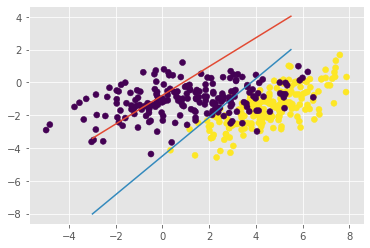

In [9]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

# plot_decision_boundary(your_model)
clf = MySGDClassifier(batch_generator, model_type="lin_reg", max_epoch=100,
                      alpha=0.001, C=10000)
clf.fit(X, y)
plot_decision_boundary(clf)
clf1 = MySGDClassifier(batch_generator, model_type="log_reg", max_epoch=100,
                      alpha=0.001, C=10000)
clf1.fit(X, y)
plot_decision_boundary(clf1)
plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [10]:
from sklearn.datasets import make_classification

In [11]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

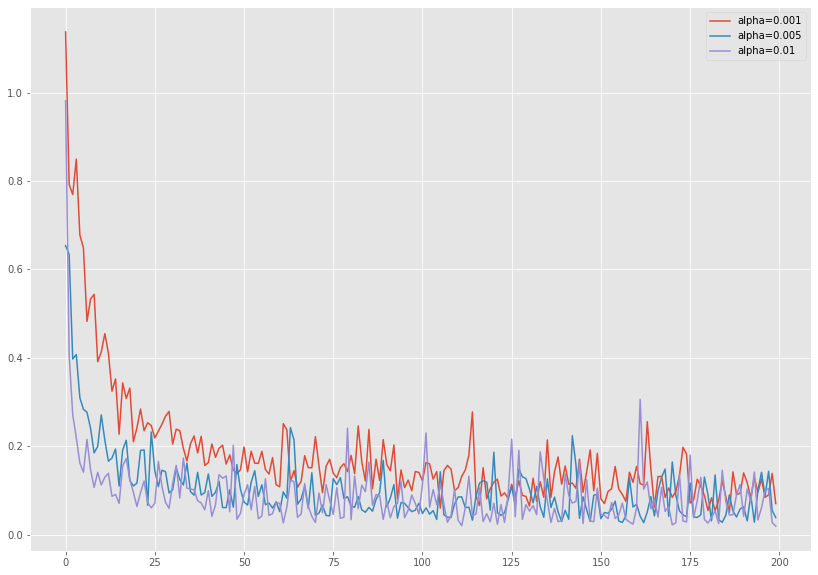

In [12]:
## Your Code Here
plt.figure(figsize = (14, 10))
alpha1 = (0.001,0.005,0.01)
N = 100
for i in range(0,3):
    clf = MySGDClassifier(batch_generator, model_type="log_reg", max_epoch=5,
                      alpha = alpha1[i], C=10000)
    clf.fit(X, y)
    x = np.arange(len(clf.errors_log['loss'])//N)
    yy = np.array([np.array(clf.errors_log['loss'][i*N:(i+1)*N]).mean() for i in range(len(clf.errors_log['loss'])//N)])  
    plt.plot(x[:200],yy[:200],label='alpha={}'.format(alpha1[i]))
plt.legend()
plt.show()

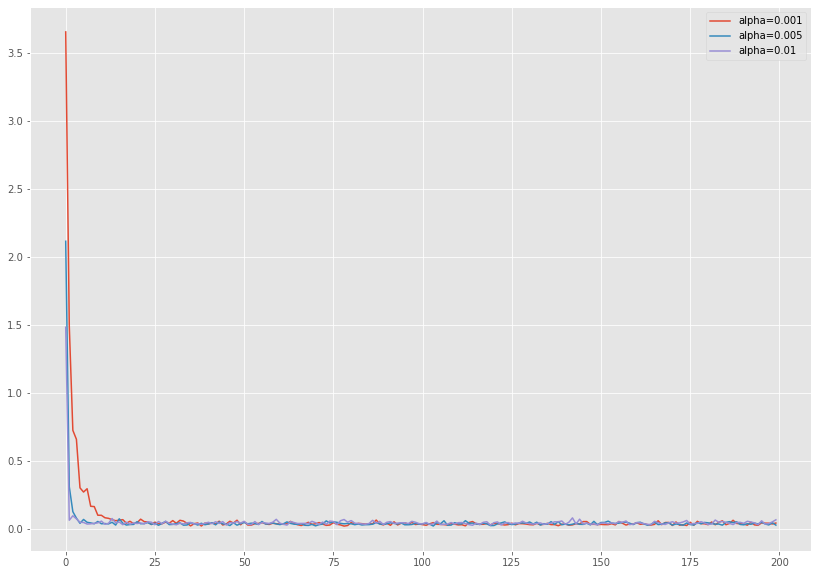

In [13]:
plt.figure(figsize = (14, 10))
alpha1 = (0.001,0.005,0.01)
N = 100
for i in range(0,3):
    clf = MySGDClassifier(batch_generator, model_type="lin_reg", max_epoch=5,
                      alpha = alpha1[i], C=10000)
    clf.fit(X, y)
    x = np.arange(len(clf.errors_log['loss'])//N)
    yy = np.array([np.array(clf.errors_log['loss'][i*N:(i+1)*N]).mean() for i in range(len(clf.errors_log['loss'])//N)])  
    plt.plot(x[:200],yy[:200],label='alpha={}'.format(alpha1[i]))
plt.legend()
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

лучше брать 0.005

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in multiply
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in multiply
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in add
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/

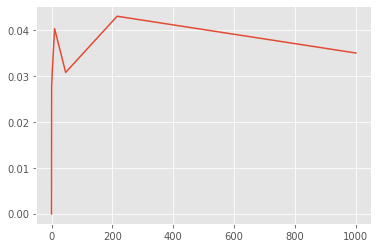

In [14]:
## Your Code Here
weights = []
C = np.logspace(3, -3, 10)
for i in C:
    clf = MySGDClassifier(batch_generator, model_type="lin_reg", max_epoch=5,
                      alpha = 0.01, C=i)
    clf.fit(X, y)
    weights.append(np.mean(clf.weights))
plt.plot(C, weights)

/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in multiply
/home/nastya

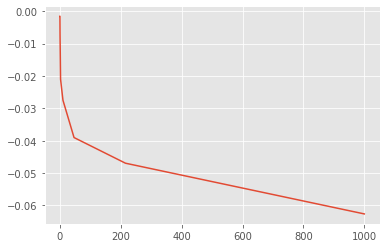

In [15]:
weights = []
C = np.logspace(3, -3, 10)
for i in C:
    clf = MySGDClassifier(batch_generator, model_type="log_reg", max_epoch=5,
                      alpha = 0.01, C=i)
    clf.fit(X, y)
    weights.append(np.mean(clf.weights))
plt.plot(C, weights)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [4]:
import pymorphy2  # $ pip install pymorphy2
  
def pos(word, morth=pymorphy2.MorphAnalyzer()):
    "Return a likely part of speech for the *word*."""
    return morth.parse(word)[0].tag.POS
  
words = "Однако я так и не смог закончить".split()
functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'} 

In [5]:
import re
doc_to_title = {}
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        r = [ i.lower() for i in re.split(r'\W+',title) if i]
        p = [re.sub(r'[^А-я]', '', i) for i in r]
        p1 = list(filter(lambda i: i, p))
        cur = [word for word in p1 if (pos(word) not in functors_pos and len(word)>1)]
        cur = [morph.parse(o)[0].normal_form for o in cur]
        title = ''
        for i in cur:
            if len(i)>2:
                title += i + ' '
        print(title)
        
        doc_to_title[doc_id] = title
print (len(doc_to_title))


ваза замена подшипник ступица нива 
ваза оптом сочи сравнить цена купить потребительский товар 
купить ступица лада калин трансмиссия переходный ступица цена замена тюнинг 
классика 
ступица нива замена подшипник свой рука 
ваза 
обзор подшипник полуось ваза 
купить подшипник ступица страница 
автомобильный интернет портал отзыв владелец ваза нива год 
новость сообщение официальный группа вконтакте торговый компания магазин тольятти 
инструкция замена подшипник передний ступица ивеко дейли 
ступица страница 
маааленький проблёмкий бортжурнал автокам год 
разгрузить полуось нива шлиц 
прошивка нива скачать файлообменник 
страница раздел каталог подвеска 
продать нива 
рекомендация проведение независимый экспертиза осаго 
втулка подшипник омск сравнить цена поставщик промышленный товар 
шеврол блейзер елабуга руководство эксплуатация инструкция совет 
привод шрусый пыльник шрусый страница 
автомобиль маз калининград интернет магазин компания стоимость каталог купить автомобиль маз цена с

диплом гражданский право процесс процедура заключение международный договор 
какой день цикл сдавать анализ гормон ттг женщина 
энтони саттон кулиса русский революция уолл стрит большевистский революция конспирология 
читать онлайн большой советский энциклопедия большой советский энциклопедия электронный библиотека 
анализ гормон женщина климакс женский совет 
символист другой статья разыскание публикация 
форум теплопункт 
гость екатеринбург онлайн 
оружейный новость архив страница 
какой день цикл сдавать ттг 
вопрос ответ тема овуляция ановуляция страница клиника гендерный медицина 
аникеев владимир научный фантастика польша весь текст 
сердечный недостаточность диабет лечение сердце 
обследование курс лечение эко 
библиотека фонд знание ломоносов 
какой день цикл сдавать гормон щитовидный железа 
задать вопрос главное врач 
диплом история человек тыл 
экстремальный состояние лев альтшулер глава книга борис альтшулер семь искусство литбук 
электронный книга рассылка 
хроника последн

видео гта прикол алекс брейн видео гта алекс брейн танк смотреть гта алекс брейн танк смотреть гта алекс брейн бикмане сделать личный номер машина гта онлайн личный номер авто гта онлайн сделать личный номер машина сделать машина личный чистый гта сан андреас хороший качество код гта сан андреас очень хороший качество скачать чистый хороший гта сан андреас качать бесплатно карта хороший качество гта сан андреас гта стоить диск карта видео стоить лнцензнный диск гта хбокс стоить гта онлайн диск 
редактор машина 
вино дизель гта 
трейнера гта вайс сити 
тачка вайс сити 
гостевой логика змея горын 

форум комментарий дневник 
модификация гта 
сообщество фанат 
уровень уровень очки тюнинг маленький уровень сервер рейтинг сервер сервер российский сервер скачать стандартный механик гта скачать стандартный пак автомобиль гта стандартный оружие гта скачать скачать стандартный уранус гта 
обновить онлайн онлайн самолёт онлайн дать друг деньга тайна онлайн онлайн лестер понтовыя кейс стать богат

холестерин кровь содержание норма повышать метод снижение 
триместр полезный информация 
весь берёзовый сок 
отечь стоить ограничивать себя 
весь причина тошнота лечение народный средство 
вывести камень почка народный средство быстро 
вода надо пить беременный околоплодный вода 
полезный совет выращивание орхидея 
ответ полезно пить много вода литр день вредный 
кора осина лечебный свойство противопоказание применение рецепт народный медицина 
водный настой сухой корка гранат излечить весь 
полезный лимон лимон полезный свойство полезный лимон лимон кулинария 
стен вконтакте 
пить много вода быть вредный полезно пить много вода 
зачем литр вода диета дружба группа 
благодатный чаять величество чаять 
берёзовый сок польза вред лечебный свойство противопоказание 
цвета мочить норма отклонение стандарт 
болезнь сердце симптом лечение профилактика куллиб классный библиотека скачать книга бесплатно 
вода 
лечение гломерулонефрит народный средство диета рецепт блюдо 
контрольный работа обме

вазомоторный ринит симптом лечение ребёнок 
насморк время беременность 
охрипнуть голос лечить 
лающий кашель ребёнок причина лечение 
карта сайт 
острый респираторный заболевание 
болезнь уха горло нос 
насморк беременность триместр лечить беременность роды 
гость екатеринбург онлайн 
сопля ребнка месяц лечить современный средство борьба насморк 
стен вконтакте 
где хороший вызвать врач дом 
способ диагностика аллергический ринит патент шамов афина гумер гомзин елена геннадий 
вазомоторный ринит 
лечение аллергический ринит вылечить насморк взрослый 
лечение вазомоторный аллергический ринит 
дермо респираторный синдром ребёнок 
центр отоларингология екатеринбург хронический ринит 
лечение туберкулёз лёгкое лечение болезнь лгкий дыхательный путь 
ответ время лечиться туберкулзти 
туберкулёз лёгкое лечение туберкулёз лёгкое противотуберкулёзный препарат 
туберкулёз лёгкое симптом лечение туберкулёз классификация туберкулёз 
ответ туберкулзти можно вылечиться совсем время займт лечение б

епископ мефодий кампанский возобновитель русский паломничество святой земля 
сервис иностранный отель турция 
золотой паук открытый литературно художественный портал жарка сибирский 
где остановиться стамбул район стамбул выбор оптимальный район исходить цель посещение город 
стамбул погода декабрь познавательный туристический портал 

кристи агата паркер пайн расследовать паркер пайн весь текст 
путешествие бисиклето ереван стамбул часть 
страховой случай стамбул путешествовать самостоятельно 
где остановиться стамбул статья 
екатонтапилиани храм сто ворота православный молитва 
какой экскурсия посетить турция лилия треветь 
литературный дневник стих 
дневник самый обсуждать тема 
город страница совет путешественник эксперт 
где остановиться стамбул отель квартира цена 
волков исход русский армия генерал врангеля крым раздел валентин крымский эпопея 
эрис описание фото турция стамбул 
стен вконтакте 
возвращение эмиграция часть проза исторический роман 
галопом стамбул 
отель турция о

заболоцкий технология здоровье запись рубрика заболоцкий технология здоровье дневник иринавиктор российский сервис онлайн дневник 
лямблия взрослый симптом схема лечение диагностика 
лямблиоз лечение народный средство обсуждение российский сервис онлайн дневник 
лечение лямблия печень народный средство здоровый волос 
пить лямблия 
просмотр профиль 
понос причина диарея взрослый правильный лечение расстройство 
карнаука тибетский медицина 
лямблия 
железосерный кластер википедия 
морфология метод исследование микроб эукариот грибов простейшее 
сахарный диабет позитивный мнение доктор пилюк 
вопрос глист ева женский интернет детский здоровье 
лечение лямблиоз взрослый обнаружение симптом заболевание 
лямблия печень что 
лямблия ребёнок симптом лечение вывести опасный 
заголовок обсуждение российский сервис онлайн дневник 
описторхоз курилка 
фитоаптека трава кавказ адрес часы работа фото отзыв покупатель телефон красноярск 
кровохлёбка лекарственный лечебный свойство противопоказание 
т

ответ соевый соус 
вареник пельмень мант 
лже мант пошаговый рецепт фото 
новогодний меню архив форум британский кошка 
соус мант приготовить правильно 
мультиварка вкусный жизнь 
запечь мидия соус приготовление 
соус сантан мант алма атинский рецепт 
рубленый мясо молодая овощ 
мяснойфарш 
фото наш блюдо рецепт мамусик 
мант мультиварка полариса пошаговый рецепт фото 
рецепт лазание соус бешамель быстро приготовить лазание соус кулинария 
соус мант люба вкус самый вкусный рецепт 
соус мант рецепт видео 
лёгкий рецепт банан 
обрезка сёмга приготовить 
мант говядина 
самовар весь мясной фарш 
блинчик обычный 
приготовить картофель оригинальный идея обсуждение российский сервис онлайн дневник 
пельмень мант рецепт 
соус мант рецепт кулинария 
рецепт голубцов фото отзыв 
готовить мультиварка тарелкин кулинарный рецепт 
искать рецепт архив страница форум русский эмигрант 
варение тыква рецепт приготовление варение 
пароварка запись рубрика пароварка дневник сонява российский сервис онлайн 

донинфо новость новочеркасск вопрос ответ заказной письмо московский асц дти 
такой авторизовать сервисный центр асц информация покупатель 
вист авторизовать сервисный центр череповец 
читать бесплатно книга интуитивный питание перестать беспокоиться еда похудеть светлана бронников 
такой асц дти 
расшифровка дти асц дти использование заказной письмо почтовый уведомление 
такой московский асц дти заказной письмо 
московский асц жалоба выигрыш 
новый словарь аббревиатура русский язык 
московский асц цех логистика чёрный дыра фгуп почта россия вконтакте 
ответ такой 
санкт петербург асц почта индекс телефон режим работа отзыв 
отзыв московский асц дти такой письмо организация 
ответ просить ответить кто знвета отличаться год гарантия асц официальный гарантия 
такой 
московский асц дти такой метка заказной письмо 
старый почтовый форум московский асц цех посылка 
московский асц дти такой 
отправить асц такой асц клуб эксперт 
авторизовать сервисный центр альметьевск 
обсуждение воровство 

можно часто ходить загорать солярий вред кожа весь загар каталог стать советчица женский интернет журнал весь 
ответ часто можно посещать солярий время занимать процедура 
вред солярий весь солярий кожа ежедневный посещение фото территория женский разговор 
загар солярий совет правило рекомендация солярий косметика солярий 
правило загар солярий можно ходить солярий 
часто можно ходить солярий совет специалист 
часто можно ходить солярий форум 
часто можно посещать солярий форум 
факт солярий 
что частый вопрос 
поджелудочный железо пельмень 
сохранить загар 
часто можно посещать солярий 
сохранить загар море можно отдых мор идти солярий 
ходить солярий просмотр тема женский форум 
часто можно ходить солярий зависимость тип кожа 
часто можно ходить солярий раз ходить солярий здоровье медицина другой 
подсказать часто можно посещать солярий 
загорать солярий правильно 
автозагар бронзата нанесение автозагар противопоказание хороший автозагар отзыв 
часто можно ходить солярий 
часто можн

самый дешёвый авиабилет казань спецпредложение авиакомпания акция распродажа авиабилет казань быстрый поиск дешёвый авиабилет 
турмалиновый коврик турманиевый коврик нефритовый коврик купить целебный мир 
морозильный камера купить казань цена отзыв 
купить слимтина казань интернет аптека цена рубль применение слимтина отзыв инструкция 
где купить теплообменник пластинчатый казань 
пульт цена казань купить дистанционка казань 
медицинский халат казань 
мебель кухня казань большой ассортемент представить новый модель 
дезмаркета компания красноярск отзыв оценка 
купить отпугиватель имитация гнездо способ избавиться химия быстрый доставка курьер москва постоять весь россия 
медилиса ципереть купить медилиса ципереть цена купить доставка россия 
казань цена где купить страница форум журнальный коллекция деагостиня ашет 
купить стерильный акушерский комплект бельё роженица доступный цена вещий роды москва 
сумка женский натуральный кожа купить интернет магазин пан чемодан 
купить металличес

решение суд требование признание недействительный решение налоговый орган часть доначисление налог прибыль ндс ндфл есн соответствующий пеня налоговый санкция частично удовлетворить решение арбитражный суд свердловский область сентябрь год 
друкер 
образец платёжный поручение год 
новость санкт петербург адвокат алексей зайцев спб 
какой налог платить работодатель 
новость 
вопрос юрист 
проверка задолженность налог налоговый инспекция нижегородский область 
подотчёт расчётный счёт 
адрес организация право потребитель ростов дон 
оплата госпошлина реорганизация 
архив вакансия ишим 
бесплатный книга образование наука рубеж 
новость сообщение официальный группа вконтакте торговый фирма гарант сервис екатеринбург юридический услуга екатеринбург 
ремонт телефон свой сила поломка телефон сломаться телефон починить телефон сервис центр 
любить проза роман 
сделка 
рыночный цена счастие литература роман 
форум ремонт атв мото инструкция мото авто 
такой автомобиль белоруссия архив форум 
сде

випэ фсин римский право контрольный работа римский право правовой дисциплина работа который выполнять много готовый работа заказ контрольный курсовой работа 
тимофеев алл история государство право россия читать книга онлайн страница 
методический рекомендация материал студент 
делать вещь умерший человек 
почему нельзя носить вещий умерший человек родственник 
реферат консенсуальный контракт римский право банк реферат сочинение доклад курсовой дипломный работа 
задание задача тема наследственный право 
база реферат всего рунет консенсуальный контракт римский право скачать реферат бесплатно реферат 
военный врач оказать помощь тысяча житель алеппо 
зачем важный оформлять завещание финансовый грамота 
криминальный бомба запорожье скандал резонанс форум запорожье 
иоанн павел святой мученник мазохист причинять себя боль 
доля завещание доля оформить доля оформить умереть умерший вступать право наследование кома отдать этот доля правовед 
юридический форум помочь решить казус римский право

гуакамоля пошаговый рецепт фото приготовить ингредиент состав время приготовление леди 
гуакамоля пошаговый рецепт фото повар 
начос сальсоя гуакамоля рецепт видео есть 
соус гуакамоля рецепт фото пошаговый приготовить гуакамоля 
приготовить гуакамоля выпуск закуска весь 
гуакамоля авокадо рецепт есть гуакамоля 
приготовить соус гуакамоля кулинарный совет любитель готовить вкусно хозяйка заметка кулинария 
готовить дом соус гуакамоля рецепт фотография ингредиент 
соус гуакамоля авокадо видео рецепт 
приготовить гуакамоля рецепт блюдо фото 
гуакамоля рецепт фото готовить 
мексиканский кесадилья кетой гуакамоля лена дом 
гуакамоля приготовить гуакамоля 
гуакамоля 
пошаговый рецепт гуакамоля паста мякоть авокадо фото приготовить ингредиент авокадо вкуснечко 
гуакамоля классический рецепт 
рецепт приготовление гуакамоля постный рецепт постный блюдо постный стол еда 
гуакамоля мексиканский закуска авокадо красный помидор красота 
гуакамоля рецепт 
гуакамоля кулинарный рецепт фото приготовит

обновить онлайн онлайн самолёт онлайн дать друг деньга тайна онлайн онлайн лестер понтовыя кейс стать богатый онлайн онлайн онлайн нужно рон онлайн принцип онлайн обзор игра гри онлайн безплатно скачать заработать звезда онлайн работать онлайн эвакуация вертолёт где взять вертолёт форт 
восстановить доступ страница контакт 
зарегистрироваться контакт номер телефон подробный инструкция 

заработать 
заработок интернет обман проверить 
время зарегистрировать ооо 
официальный информация 
обзор судебный практика верховный суд российский федерация экономика жизнь 
создание страница одноклассник пошаговый инструкция создание личный страница 
невидимка одноклассник 
зарегистрировать страничка соц сеть сим карта сайт валентин 
следить человек абонент мтс 
обзор судебный практика верховный суд российский федерация 
стен вконтакте 
новость сообщение официальный группа вконтакте политический партия коммунист россия юридический услуга красноярск 
порядок межевание земельный участок 
заполнить учёт

дневник мама весь детка детка блог мой бэтэшка 
фото букля ева 
лечение варикоз ноготок 
календула полезный свойство противопоказание 
глава лечение кандида экстракт семя грейпфрут экстракт семя грейпфрут сакс аллан перевод александр копия 
болезнь трихомонада женщина совет женщина 
стрептоцидовый мазь прыщ хороший помощник ваш проблема 
домашний гомеопатия страница архив ответ врач общий практика асадулина вадим ахняф форум счастливый родитель 
выбирать свой малыш шампунь волос родительство 
пришвино михаил михайло колобок 
гепатит лечение традиционный народный средство 
лечение остеохондроз народный средство опасный 
полынь горький применение свойство лечение обсуждение российский сервис онлайн дневник 
сохранить потерять 
экологический растениеводство 
рецепт известный народный целитель лечение фиброзный кистозный мастопатия 
жидкость снятие лак ноготок отзыв 
полоскание горло хронический тонзиллит ангина тонзиллитик 
лекарство улья лечение природа 
персиковый масло волос применение

наушник собака ассортимент необычный наушник купить недорогой цена продажа подарок креативный наушник телефон плеер низка цена карамб магазин подарок сувенир 
газета неделя саратов 
бруцеллёз результат поиск информационно рекламный аграрный газета агроинфо 
дневник домовый официальный сайт кирилл белоусов 
информационный портал акимат город балхаш 
биржа 
зоорынок продажа животное казахстан весь зоорынок казахстан один сайт 
какой город казахстан продаваться самый дешёвый хлеб павлодар онлайн павлодар новость павлодарский городской портал 
новость казахстан 
новость казахстан 
цементный завод шымкент остановить ремонт рассылка 
стен вконтакте 
домик кошка собака изготовление мебель животное бизнес форум 
материал год страница матрица 
общественный фонд мир евразия 
дебаты запрет продажа щенок 


весь категория 
карта раздел портал 
дайджест китай международный арен 
новость северо кавказский федеральный округ 
отдел образование город каражал карагандинский область 
обзор событие казахс

монодиета похудеть килограмм домашний условие 
сам себя диетолог похудеть домашний условие 
похудеть домашний условие польза здоровье 
избавиться бородавка рука нога домашний условие 
быстро похудеть домашний условие способ совет 
диета продукт похудение худеть неделя биослимик низкокалорийный диета похудение домашний условие леовить официальный сайт леовить 
отбелить зуб домашний условие быстро отбелить зуб народный средство 
быстро похудеть 
похудение натуральный средство 
рецепт похудение домашний условие лечение народный средство домашний условие 
делать лицо похуделый лечение трава рецепт народный медицина 
быстро избавиться синяк народный средство лечение синяк дом 
народный способ похудение домашний условие 
эффективный народный средство похудение домашний условие 
похудеть домашний условие день народный средство 
быстро похудеть домашний условие 
уменьшить аппетит вечером похудеть домашний условие 
быстро похудеть неделя похудеть домашний условие вес фитнес похудение 
похудеть 

автоматизация информатизация технологический процесс металлургия теория разработка реализация интегрировать программный комплекс управление технология доменный цех интеграция отчтной информация корпоративный сеть предприятие 
маликов пылькина жулев практический курс электронный таблица операционный система программа скачать бесплатно смс регистрация 
презентация тема интерфейс принцип работа скачать бесплатно 
служба доставка овощ фрукт лето центральный район адрес часы работа фото отзыв покупатель телефон красноярск 
книга бухгалтерский налоговый учёт делопроизводство малое бизнес александр трус купить книга читать рецензия лабиринт 
отчёт месяц москва 
основной действие информация общий сведение 
дневник российский сервис онлайн дневник 
курсовой работа дисциплина информатика тема инструментальный средство пользователь среда 
урок работа внешний база дать 
распечатать один лист 
пример авс пример оптимизация закупка запас средство 
распечатать страница один лист другой полезность раб

урок освоение комп запись рубрика урок освоение комп дневник светик российский сервис онлайн дневник 
август 
служба поддержка вконтакте сайт 
прикладной информатика лабораторный практикум 
клубный наклейка архив 
клип 
искусство нарушить 
незабываемый рождество читать онлайн электронный книга незабываемый рождество 
мама серия маша кукла эмиль подружка искать подарок новогодний ёлка видео 
составитель нил гейман саррантонио автор коллектив авторовсерия антология сторнка 
воспитывать тихий ребёнок мир который они слышать 
гретель повесть википедия 
глава один литератор джим хокинс 
майн рид морской волчонок повесть писать вместе культура литература 
инк конкистадор история испанский завоевание век хэммонд иннеса мир индеец 
скачать клип мама серия готовить пикник печение плей бести бон эмиль чичилава подружка скачать клип бесплатно 
стен вконтакте 
мама фильм большой подходить название три странный тётка материнский любовь забота фильм ноль отзыв покупатель 
быть матерь свой ребёнок др

державин река время свой стремление уносить весь дело человек топить пропасть забвение народ царство царь 
ответ почему пушкинский сюртук писаться большой буква пушкинский стих маленькая 
образ русалка произведение пушкин лермонтов реферат читать текст 
заглядывать встарь академический словарь пушкин евгений онегин 
поставскай библиотека 
институт русский цивилизация 
методический рекомендация учебник литература класс редакция маранцман читать бесплатно онлайн электронный вид страница единый окно 
никитин 
чаадаев жизнь творчество пушкин курсовой работа читать текст 
журнал международный жизнь архив журнал номер год 
елена семновый гоголь ступень семь небо московский прихожанин храм новомученик исповедник российский читать принимать сведение 
стен вконтакте 
новый сочинение весь тема класс сочинение литературный тема сидоренко 
репортаж воробушек проза роман авантюра 
реферат пушкин повесть белкин 
влияние кавказ творчество лермонтов студенческий научный форум февраль март год 
библиот

такой континент они 
материк земля материк миллион километр 
оформить дарственный образец договор дарение гараж 
кома принадлежать курильский остров спорый россия япония 
подготовка почва теплица сад огород 
правильно сеять морковь газета садовод сетевой издание 
читать книга константин эдуардо циолковский промышленный освоение космос 
пришлый время сажать картошка условие хороший урожай российский газета 

следопытство след передвижение строение конечность походка эльфийский кладовая форум эльфхейм 
выращивание зелень продажа бизнес план 
фитофтора помидор бороться 
клетка биологический система 
материк земля 
рассчитать земельный налог физический лицо год 
какой наука изучать земля 
туй посадка уход туй уход зимой 
земля зародиться жизнь сто тысяча почему почемучка 
земля материк 
земля один человек ева женский интернет весь остальной 
отзыв произведение девушка планета земля 
материк земля они называться 
признак судный день ислам дагестан 
вырастить лес 
америго веспучча происхожде

ответ пяточный шпор она бороться 
тератабластома поражение узел подсказать русский онкологический форум 
чак паланик бойцовский клуб 
парафиновый аппликация такой парафиновый аппликация 
реферат медицина уход кожа ребёнок 
нопэрапон 
кожный запись рубрика кожный дневник российский сервис онлайн дневник 
реинкарнация здоровье настоящее 
чепеть диагностика лечение болезнь сустав весь текст 
дневник российский сервис онлайн дневник 
церезин такой церезин 
детский диатез здоровье медицина нерюнгри 
барановский вероника дцп нужный реабилитация сообщение 
парафинотерапия лицо домашний условие приятный удовольствие омоложение 
парафинотерапия такой она применять правильно 
лечение радикулит медикаментозный вмешательство 
заразный гепатит неактивный форма 
быть здоровый рассылка 
такой кокцигодиния лечиться 
парафинотерапия рука такой 
обретать бог елена хотулевый проза 
томск март зимний триатлоно велоклуб сотня кирово чепецк 
вопрос ответ 
дегенеративный дистрофический изменение шейный отдел

запись детский сад официальный портал администрация город омск 
ольга бугров работать индивидуально каждый заявитель 
чёрный список должник кредит неплательщик проверить где посмотреть невыезд граница 
меденцов александр шпаргалка предпринимательский право весь текст 
овощеводство обзор статьть журнал 
удалить запись трудовой москва 
решение май судакт 
инвалид получить положить ипр милосердие 
особенность правовой регулирование труд иностранный гражданин 
формирование госзадание автономный учреждение 
российский профсоюз железнодорожник транспортный строитель 
шумерля чувашский республика материал газета вперёд 
алтай гималаи 
библиотека фонд знание ломоносов 
нужный транзитный виза 
волчий порубежье просмотр тема мезенцев энциклопедия чудо том 
форум весь птица ночной братва 
экадаша лунный календарь экадаша 
год карахан ашот эдуардо стих 
американский виза самостоятельно пошаговый инструкция 
беседа шестоднев 
семнадцать день весна 
тула греция закинтос отчта автопутешествие автотур

эйдельман натан лунина весь текст 
новость 
вопрос типичный феодал мамилов дахкильгов 
вести водоём страница сайт новосибирский рыбак 
новость 
шафаре социализм явление мировой история часть 
какой значение следовать поставить платёжный поручение пол основание платёж журнал главбух 
василий беднов православный церковь польша литва 
электронный библиотека ирлить рана собрание текст библиотека литература древний русь тот повесть временной год 
тема государство право период становление абсолютный монархия кон перв четво век 
великое памятник 
пакет кадровик консультация снежана форум кадровый портал кадровик 
цска москва арсенал тула блог 
правило внутренний распорядок исправительный учреждение право закон адвокат екатеринбург 
образец заполнение платжный поручение год москва 
ответ какой основание платёж указываться платежка уплата штраф пеня налог пол основание платёж 
базовый курс рынок ценный бумага куллиб классный библиотека скачать книга бесплатно 
следователь правовой положение 
ср

мариновать помидор болгарский перец обсуждение российский сервис онлайн дневник 
чарльз тилль демократия форум солнечногорский газета думать человек 
изюм 

западный ствол 
валентин скляренко знаменитый знаменитый катастрофа весь текст 
сила бесстыдный тело саус парк блог 
заголовок обсуждение российский сервис онлайн дневник 
землетрясение чили весь вокруг православный письмо алексей аэдый православие мир 
война рэкет легетимный террорист 
физик мораль космический этика 
поэзия подземный переход трип литература тихий 
культура чили 
сознание политический система 
цвета сверхдержава красный восхождение часть 
письмо мой израильский друг обсуждение российский сервис онлайн дневник 
гражданство чили иммиграция чили 
любимый интересный актёр 
библиотека 
знак обратить вечность куллиб классный библиотека скачать книга бесплатно 
котов шутка всерьёз шутка всерьёз 
ответить комментарий учебный центр корпоративный обучение семинар бизнес тренинг продажа управление персонал тренинг 
агата крис

поводок карповый 
вариант правильный монтаж отводный поводок оснащение спиннинг основной элемент оснастка 
сделать поводок рыбалка 
поводок рыбалка карповый поводок рыбалка 
инструмент камень круг отрезной камень оборудование камень инструмент камень инструмент камень фреза камень химия камень пескоструйный аппарат песок пескоструить 
отводный поводок начинающий рыбалка информационно развлекательный портал 
гулять собака хотеть взять поводок нету заменить удочка мем типичный игрок рисовач 
поводок рыбалка поплавочный удочка вязать оснащать 
снасть отводный поводок самоделка рыбалка свой рука 
ответ сделать поводок морской свинка хотеть сделать свинка морской поводок свой рука 
сделать поводок удочка видео урок 
сделать самодельный поводок спиннинг копилка рыбацкий опыт 
поводок жерлица страница рыбалка граница центральный форум рыбак 
поводок 
поводок спиннинг поводковый материал 
металлический поводок гитарный струна 
сделать улучшить поводок гитарный струна рыбалка информационно разв

монтаж стена профнастил свой рука использование профнастил строительство стена стена профнастил свой рука каркасный строительство профнастил свой рука металл звонок 
облицовка наружное стена дом кирпй 
обшить фасад профлист сообщество взаимопомощь 
обшить фундамент профлист немного строить сам 
обшивка цоколь профлист вид профнастил обшить стоимость работа цена профлист где купить москва спб 
обшивка фундамент металлический профилировать лист 
сделать сам обшивка фундамент профилировать лист строительный форум 
обшивка дом профнастил обшить стена облицовка 
спасмо ваш дом дом дерево основной технология строительство 
технология обшивка фасад профнастил 
отделка фундамент панель подготовка облицовка видео 
фасад профнастил видео инструкция отделка металлопрофиль здание свой рука цена фото 
отделка фундамент дом профлист свой рука инструмент материал облицовка металлический профилировать лист обшивка фото совет рекомендация инструкция 
обшивка дом профнастил совет инструкция мужик дом 
о

просмотр тема кузов паджеро 
газон сквер городской областной новость форум череповец 
найти помещение аптека 
логотип одуванчик 
таможня база дать товарный номенклатура вэд еаэс пояснение 
екатеринбург появиться информационный табличка пешеход 
хороший мыть посуда социальный сеть работник образование 
помощь расширить редактор сделать таблица большой количество картинка обсуждение российский сервис онлайн дневник 
сделать минь игра маинкрафт мод 
сделать карниз штора фото свой рука 
оценка фирменный стиль магазин радуга формирование фирменный стиль торговый предприятие сергеев 
предупреждение нельзя август эвакуировать машина екатеринбург стать сложный 
массовый полиграфия 
земельный кадастровый предприятие 
наука финансовый право ярославский демидовский лицей 
белогвардейщина такой мнение статья казачий круг 
гражданский право часть 
алекс спиро сайт 
новость компания бухгалтерский новость 
совершенствование доход расход национальный банка украина банковский дело дипломный база диплом

измениться зарплата средний потребительский цена россия год пора валить эмиграция россия 
курс валюта таблица доллар евро квадратный метр квартира москва 
курс валюта курс доллар курс евро год 
падать рубль россия начало лето год экономика бизнес тасс 
рубль стоить доллар год 
быть стоить доллар россия год курс 
курс доллар 
курс валюта таблица доллар евро квадратный метр квартира москва 
максимум обвал динамик цена нефть год экономика бизнес тасс 
курс доллар сша евро 
стоить человек ребёнок орган рабство 
курс доллар сша евро установленный банк россия 
инфляция доллар год сравнение российский валюта личный финансы 
ответ стоить доллар год 
курс доллар год россия рубль быть 
курс доллар отношение рубль год 
ответ мочь кто помнить стоить доллар год назвать средние стоимость 
курс валюта курс доллар курс евро год 
курс валюта таблица доллар евро квадратный метр квартира москва 
стоить рубль качество 
ящик пандора стоимость нефть доллар власть россия поменяться 
рубль действительность ст

цитомегаловирус вирус папиллома человек впч кто лечиться нужно вообще лечиться беременность 
аднексито явный симптом причина опасный последствие мера народный лечение 
врач гинеколог определять беременность 
посоветовать хороший врач акушер гинеколог консультация врач медицинский портал пенза 
какой лекарство необходимый принимать ранний срок 
дисфункция яичниковый беременность причина симптом лечить 
беременность отмена 
симптом внематочный беременность заранее распознать ранний срок 
миома матка 
вдм неделя беременность неделя беременность 
узи плод адлер какой клиника хороший сделать счастливый беременность страна мама 
узи аборт медикаментозный прерывание беременность 
консультация 
месячный прима дюфастон 
выделение посещение гинеколог весь быть шок 
новость сообщение официальный группа вконтакте центр женский здоровье медицинский центр калининград 
девушка спрашивать жизнь фотография фото жизнь юмор демотиватор 
материал отфильтровать дата май 
овуляция женщина симптом признак лю

слушать радиолюбитель можно интернет помощь онлайн приёмник этот два возрождение россия 
лайна радиолюбительский радио 
эфир слушать 
слушать интернет архив форум радиолюбитель украина 
радиоприёмник телевидение интернет каталог сайт прилуки сайт радиолюбитель 
радиолюбительский эфир интернет блог блог геймер игровой блог создать блог вести блог игра 
выйти эфир компьютер радиохулиган радиолюбитель техника интернет школажизнь 
связь форум радиолюбитель смоленщина 
можно сейчас послушать 
спутниковый радиосвязь 
послушать приёмник онлайн 
радиолюбительский программа каталог файл айта радиолюбитель 
онлайн радиопримник укв бэнд форум ростовский автомобильный радиоканал 
примник красноярский форум радиолюбитель 
программа прослушивание интернет радио компьютер радио онлайн 
слушать радио ответ здесь 
ответ друг подсказать можно интернет слушать радио любитель 
журнал радио схема радиолюбитель 
программа прослушивание интернет радио компьютер радио онлайн 
виртуальный радиолюбительский тра

хороший исторический сериал похожий викинг 
кто самый крутой мужчина мир рассказать сша нтв 
самый крутой чувак мир смотреть онлайн видео убивашка хороший качество 
самый крутой сериал мир популярный запись 
хороший сериал год 
сериал смотреть лайна сайт кинотеатр хороший фильм сериалысмотреть лайна сайт кинотеатр хороший фильм сериал 
самый длинный сериал мир длиться год фактрум 
рейтинг сериал хороший сериал год 
хороший сериал место финал 
три самый крутой сериал год уходить сообщество киномания 
самый длинный сериал мир книга рекорд гиннес мировой рекорд достижение 
рейтинг хороший сериал мир рейтинг 
главное сериал сезон версия фильм новость фильм 
хороший сериал кинопоиск 
афиша воздух выбор афиша архив 
самый хороший сериал мир год хороший 
самый длинный сериал мир блогер сайт сентябрь сплетник 
хороший комедийный сериал весь время блог сайт телеканал 
самый рейтинговый сериал мир классный крутой 
хороший сериал самый хороший сериал 
итог необходимый сериал тотальный гид хороший

постановление главный государственный санитарный врач ред мбоу сош имя конгар бай талый бай тайгинский кожуун республика тыва 
отчёт 
отчёт самообследование 
выплата процент дарственный квартира 
нестандартный династия вопрос предложение архив страница новость обзор дополнение файл код объект скина скриншот сим форёв 
раз год иметь право собственник временно регестрировать 
регистрация яплакалъ 
жилищный субсидия сотрудник полиция 
какой документ нужный прописаться квартира 
совет человек взять ипотека 
портал россия библиотека россия делать 
часто задавать вопрос учёба испания 
новость сообщение официальный группа вконтакте туристический агентство карта мир финансы братск 
дорога никуда книга два часть один виктор дьяк проза 
снос переселение пятиэтажка северный медведково страница форум район северный медведково южный медведково 
бланк заявление прописка регистрация квартира новорождённый форма ребёнок место жительство матерь 
нужно иметь квадратный метр собственность прописаться ква

необычный задачник обычный гражданин сборник задача задание подросток старшеклассник читать бесплатно онлайн электронный вид страница единый окно 
лапшин зорька 
пролетарский революция ленинский номер 
поделать самый дело застенчивый отчасти робкий 
сила описание путь успех бизнес учебный центр корпоративный обучение семинар бизнес тренинг продажа управление персонал тренинг 
новогодний праздник подготовительный школа группа 
отложить постинг вместе сервис 
христос воскрес наш христос птаха творча маста 
добавить группа супергруппа телеграмма 
бесплатный книга деловой туркмения 
быть красный леворадикал 
историк марксист год младой бухарец 
опрос главарь третье рейх российский газета 
приказ ноябрь москва делопроизводство система фмс россия цель совершенствование документационный обеспечение управление система федеральный миграционный служба страница 
битва берлин сборник воспоминание 
тяжело учение армия россия страница винтик шпунтик руссобалт 
палеонтология цитата книга 
читать книг

платина шоколад фанфик хороший фанфик рунет 
стен вконтакте 
метод эстивиль научить ребёнок спать комаровский форум 
артур самарь забытый царство согд 
шолпо инна список чтение испортить ребёнок лето журнал литература 
лысенкова легко учиться педагогический поиск 
библиотека 
книга журнал статья 
подсказать интересный книга дневник 
какой возраст начинать читать сказка 
краткий содержание капитанский дочка пушкин хороший краткий содержание 
екатерина вильмонт скачать книга бесплатно читать онлайн телефон 
книга подросток девочка 
материнство 
девочка медведь 
читать игрушка 
наладить отношение подросток пономаренко психологос 
художественный книга индия произведение полный погружение индийский реальность 
кто читать архив страница форум 
гоголь тарас бульб читать онлайн русский исторический библиотека 
ответ какой книга можно прочесть год девушка 
полный текст выступление мегр читательский встреча который состояться германия возле штутгарт звенящий кедр россия новость фото книга цитата

ароматический эфирный масло дух любимый запах форум тайский кошка тайский кошка котёнок клуб тайский кошка 
форум весь птица русский версия 
соус оливковый масло лимон 
диета перрикона страница диета правильный питание космофорум 
выбирать фрукт правильно 
правильно приготовить суп солянка мультиварка 
приготовить лимончелло домашний условие самогон самогон 
шашлык обсуждение российский сервис онлайн дневник 
выбрать соковыжималка 
филе акула соус морепродукт 
очищение кишечник домашний условие клизма 
заголовок обсуждение российский сервис онлайн дневник 
приготовить шницель 
самый вкусный никакой диета 
приготовить креветка пиво секрет здоовие красота 
правильно выбирать креветка хороший журнал онлайн 
огурец лимон похудение 
правильный масло защитить ваш кожа плохой погода 
вкусно правильно приготовить креветка 
правильно выбирать креветка весь хотеть спросить 
правильно выбрать лимон магазин сантиметр 
татьяна кудинов вконтакте 
пить худеть правильно использовать имбирь похудеть об

ответ участник русский поимя девочка карлик звать 
кто исполнять 
википедия 
соломкий музыка скачать бесплатно слушать музыка соломкий песня песнь онлайн 
материнство евровидение 
скачать новинка музыкальный хит бесплатно регистрация 
клип кара мэн смотреть клип онлайн 
программа курс 
табуретка мир владимир савич ковчег литбук 
меломан архив страница подосиновский районный форум 
история хип мой статья хип новость 
глава сводка анализ 
инк русский скачать бесплатно регистрация качать бесплатно любой музыка формат онлайн 
скачать тамерлан музыка слушать онлайн найти песнь песня 
рэп архив форум готический субкультура 
крриша архив страница форум 
страничка меломан вконтакте 
библиотека фонд знание ломоносов 
текст песнь перевод слово песнь видео клип 
текст песнь видео 
смотреть онлайн хороший качество 
правило блэк металлист форум первоуральск 
ответ кто петь песня 
скачать песнь лайм вайкуль бесплатно музыкальный подборка альбом исполнитель лайм вайкуль слушать музыка онлайн зайцев н

общероссийский классификатор вид экономический деятельность оквэда кдес ред ввести действие постановление госстандарт изменение дополнение отменный 
классификация код вид деятельность обновление материал 
внесение изменение закон челябинский область применение индивидуальный предприниматель патентный система налогоо законодательный собрание челябинский область 
постановление арбитражный суд центральный округа дело ключевой тема вид экономический деятельность класс профессиональный риска страховой тариф профессиональный заболевание обязательный социальный страхование 
код вид предпринимательский деятельность енвда 
распоряжение организация работа актуализация показатель паспорт организация социальный сфера московский область находиться государственный собственность московский область собственность муниципальный образование московский область организация социальный сфера иной форма собственность расположить территория московский область открытый дать 
предоставление грант сахалинский обл

мой документ социальный сеть работник образование 
снизить стоимость регистрация продление домен зона регистратор 
анкета придуманый персонаж спирит душить прерия 
создание форма анкета опрос 
заработать деньга анкета 
соответствие некоторый отечественный зарубежный фактор 
анкета форма скачать пример заполнение форма личный карточка работник форма скачать образец заполнение бланк 
опрос анкета создать интернет опрос бесплатно 
форма бесплатно создавать собственный онлайн опрос 
анкета обычный перс 
информационный агентство 
предоставление анкета лпу приказ минздрав республика татарстан январь год 
создать гугл форма опрос 
анкета канон хвост фея ролевый беседа вконтакте 
развитие воспитательный потенциал семья условие сетевой взаимодействие семья образовательный учреждение современный социокультурный условие 

утверждение документ проведение аттестация государственный аккредитация дошкольный образовательный учреждение 
создать анкета блог территория млм 
орлов менеджмент маркетинг 
пр

курс гривна беларусь минск сегодня обмен рубль евро хороший курс валюта гривна белорусский рубль банка 
хороший курс сегодня 
курс доллар минск сегодня финансы 
курс валюта минск хороший курс обмен банка обменник сегодня 
оао белинвестбанк 
курс евро банка минск беларусь сегодня курс конверсия евро доллар российский рубль 
курс валюта весь банка беларусь курс доллар курс евро 
белинвестбанк услуга банка кредит вклад курс валюта банкомат отделение 
курс покупка продажа конверсия наличный иностранный валюта 
курс валюта мозырь хороший курс сегодня курс конверсия валюта 
обменник поиск хороший курс валюта банка беларусь минск 
технобанк кредит вклад курс валюта карточка банкомат 
беларусбанк весь банка беларусь 
курс валюта банка минск весь беларусь сегодня финансы 
курс валюта курс доллар евро конвертер валюта 
курс валюта минск сегодня курс доллар евро российский рубль обмен валюта 
курс минск бизнес курс компьютерный курс мастер курс 
курс обмен валюта сегодня завтра банка минск белару

областной депутат посетить ярославский онкологический больница 
русский история редкий иллюстрация иллюстрация куллиб классный библиотека скачать книга бесплатно 
печать страница репрессия личный состав ркк 
список аджимушкаец книга память керченский полуостров 
ростов великий очаровывать первое взгляд интерфакс туризм 
ярославский храм усекновение глава иоанн предтеча толчковый православие 
апрель форум 
интернет 


игра создание персонаж симс андроид 
установить поисковик музыка 
скачать заявление должность 
новость мир 
прошивка поддельный 
скачать бесплатно 
март 
скачать торрент русский скачать программа торрент бесплатно регистрация 

новое видеокарта тюнер карта захват спутниковый 
обновление английский русский молоджный развлекательный портал 
установить доработка 


ключ бесплатно 

аудиоредактор открытый бесплатный портал регистрация рейтинг 
смешной видео чистый паржать архив клуб владелец кроссовер 
воспроизведение общедоступный медиафайл сеть урок каталог стать обзор выбор

диплом дидактический возможность отдельный метод обучение урок литература старший класс 
тургенев сочинение литература класс сочинение литература класс скачать бесплатно март 
отзыв книга бирюк 
устный история 
карта сайт 
рабочий программа литература класс разработать основа примерный программа основный общий образование литература соответствовать федеральный компонент государственный стандарт общий образование литература 

стен вконтакте 
периодический печать россия век 
русский литература шпаргалка 
иван сергей тургенев бирюк книга 
троицкий андрей борис фальшак весь текст 
реферат практикум анализ художественный произведение методический рекомендация выполнение письменный работа 
сведение 
рабочий программа литература учащийся класс педагог наумов ирина евгений 
синдром экологический мародёрство 

вебмастер 
конвертер вконтакте скачать 
скачать видео лайфхакер 
скачать видео программа новый плеер смотреть онлайн видео юрий шатохин хороший качество 

безкоштовен завантаженний безкош

оформление загранпаспорт новое образец получить биометрический загранпаспорт отпечаток палец санкт петербург 
оформление загранпаспорт документ заявление заграничный паспорт 
оформить загранпаспорт интернет портал госуслуга 
регистрация сайт госуслуга инструкция 
оформить загранпаспорт документ загранпаспорт 
оформить российский загранпаспорт крым севастополь 
оформить загранпаспорт 
загранпаспорт госуслуга инструкция оформление интернет 
что начать оформление загранпаспорт оформление загранпаспорт спб 
оформить загранпаспорт сочи можно сходить место 
оформление заграничный паспорт содержимый электронный носитель информация услуга заграничный паспорт перечень документ паспортный визовый центр москва 
уфмс россия иркутский область 
процедура оформление загранпаспорт овира украина киев 
официальный сайт уфмс россия саратовский область 
где получить загранпаспорт нижний новгород 
загранпаспорт 
оформление биометрический загранпаспорт украина путешествовать самостоятельно 
оформление загра

калория дыня колхозница торпеда килограмм дыня калорийность дыня грамм сушёный дыня 
дыня лекарство афродизиак польза вред дыня 
калорийность дыня 
калорийность дыня калория дыня колхозница торпеда 
калорийность дыня особенность свойство 
калория дыня калорийность торпеда колхозница 
дыня калорийность полезный свойство польза вред описание 
калорийность дыня калорийность продукт 
дынный диета похудение меню отзыв 
дыня калорийность полезный свойство вред польза 
калория дыня 
дыня калорийность грамм польза вред дыня 
польза калорийность дыня торпеда колхозница 
пяточный шпор лечение народный средство домашний условие 
шпор пятка лечить 
вылечить пяточный шпор дом основной метод 
пяточный шпор боль пятка ходьба лечить 
лечение пяточный шпор домашний условие рецепт 
лечение пяточный шпор народный средство быстро эффективно 
пяточный шпор лечение домашний условие 
лечить пяточный шпор домашний условие 
пяточный шпор 
пяточный шпор лечить быстро 
пяточный шпор лечение народный средство пят

справочник лекарственный средство лекарственный препарат россия 
методический рекомендация самостоятельный работа студент курс медицинский факультет специальность 
список препарат бета блокатор механизм действие классификация противопоказание побочный эффект 
инфаркт миокард стенокардия сердечный недостаточность 
небиволола тева инструкция применение цена отзыв медикамент лекарство 
постельный бельё романтика валенок мужской рабочий тайга 
отзыв покупатель эуфиллина раствор инъекция отзыв 
эгилка инструкция наличие цена новокузнецк рубль 
тимолоть мэз 
алгоритм лечение артериальный гипертензия медицина здоровье 
тема лекция практический занятие клинический фармакология год 
адаптер измерение артериальный давление 
лечение гипертония медикаментозный народный средство 
анестезия хирургический эндокринология мегалекция 
медицина история болезнь терапия ишемический болезнь сердце 
бета адреноблокатор лекарство препарат 
таблетка снижение давление обзор препарат 
лекарство бетофтан инструкц

сад парка санкт петербург история парковый владелец добраться 
посмотреть санкт петербург маршрут прогулка достопримечательность невский 
музей санкт петербург 
куда сходить санкт петербург день 
посмотреть санкт петербург 
редкий малоизвестный достопримечательность петербург достопримечательность санкт петербург 
посмотреть санкт петербург россия совет путешественник куда сходить 
эрмитаж достопримечательность санкт петербург 
посмотреть санкт петербург основной достопримечательность новость тюмень тюменский область 
витебский царскосельский вокзал достопримечательность санкт петербург 
посмотреть санкт петербург 
делать петербург зимой прогулка петербург 
евразия 
посмотреть санкт петербург зимой 
гостиница санкт петербург бесплатный бронирование смотреть посетить санкт петербург 
гастрономический санкт петербург хороший заведение который следовать посетить 
аничков дворец невский проспект санкт петербург 
посмотреть санкт петербург азбука турист 
посмотреть санкт петербург достоприм

распознать защититься энергетический вампир читальный зал мирт 
энергетический вампир они обнаружить защитить себя 
защититься психологический вампир 
энергетический вампир здоровье 
энергетический гигиена восстановить энергия нападение вампир 
энергетический вампир распознать защититься обсуждение российский сервис онлайн дневник 
защититься энергетический вампир 
энергетический вампир отличить защититься 
ответ защититься энергетический вампиризм семья родственник сложный всего 
хватать жизненный энергия защититься энергетический вампир 
энергетический вампир защититься энергетический вампир способ защита вампир противостояние энергетический вампир распознать вампир информационно справочный портал беларусь 
уберечься энергетический вампир 
энергетический вампир признак защититься 
энергетический защита вампир избавиться вампиризм обсуждение российский сервис онлайн дневник 
энергетический вампир биоэнерготерапия 
энергетический вампир самый интересный блог 
энергетический вампир офис

качественный детализация скачать скачать паинт скачать гта пиратка гта скачать пиратка альфа скачать гта пиратка где скачать гта пиратка прохождение управление прохождение посмотреть видео скачать чита гта возвращение лос сантос чита гта возвращение лос сантос бесконечный патрон скачать сэйв гта возвращение лос сантос 
хотеть новый королевство кривая зеркало архив страница 
личный кабинет аср 
сервер отвечать помощь 
компьютер интернет запись рубрика компьютер интернет дневник российский сервис онлайн дневник 
прописать килла рулетка рубль 
создать свой сервер 
хороший скрипт сервер гта сампа 
функция создание контекстный меню разный форум 
блог бесплатный скрипт заработок интернет страница 
мир психология психологический чат 
установка плагин установить плагин вордпресс вручную 
неофициальный прошивка 
сообщество руководство открыть порт 
изготовление сайт услуга форум 
оффтоп технический поддержка архив страница 
какой купить роутереть ева женский интернет цифровой мир программный об

комментарий стихотворение весь россия россия история энциклопедия новость фото федерация 
погода балашов декабрь подробный точный прогноз день рамблер погода 
экстремальный состояние лев альтшулер глава книга борис альтшулер семь искусство литбук 
вершина спинальник чуть медленный белопух 
новость событие тамбовский библиотечный портал 
изюм 
воспоминание генерал обвинить шпионаж 
саратов крым часть путешествие байкпост 
роль метафора текст научный публицистика реферат 
бсэ золототысячник зооспора 
застигнуть ночью дневник человек время перестройка книга два николай коняев север литбук 
февраль повысить пенсия ноябрьскинформ 
погода балашов месяц прогноз погода день балашовский район саратовский область россия 
сергей иванов начальник фгб обь иртышский управление гидрометеорология мониторинг окружающий среда проблема неточность прогноз погода тот большинство омский сми пользоваться информация росгидромет 
юбилей непослушание 
волчий порубежье просмотр тема система русский обрядовый пес

заготовка запись рубрика заготовка дневник российский сервис онлайн дневник 
компот чрной смородина зима рецепт фото 
диета больной инфаркт миокард 
рецепт вино домашний приготовление самый популярный рецепт обсуждение российский сервис онлайн дневник 
удалить пигментный пятно обсуждение российский сервис онлайн дневник 
заголовок обсуждение российский сервис онлайн дневник 
консервирование баночка летний солнце совет кулинарный рецепт фотография журнал гастрономъ 
дикий кабан приготовить мясо кабан 
пчёлка пчёлка вконтакте 
форум родитель питание месяц 
дневник галинка российский сервис онлайн дневник 
форум родитель торт выпечка делиться опыт 
елена селюковый вконтакте 
секрет современный жизнь вконтакте 
меню детячий 
чудо дыня зима 
пищевой продукт овощ фрукт ягода 
порассуждать помощь огород 
хороший способ подключить роутереть компьютер 
ответ подключить роутереть 
подключение настройка роутер 
маршрутизатор обсуждение настройка конференция 
подключить роутереть компьютер подключ

тот сторона воображать символический маленький другой большой теория фрейд техника психоанализ 
ноябрь день дарение огонь семь греть свечка кален дар 
разный 
псориаз волосистый часть голов лечение симптом причина 
мир тонкий энергия послание непроявленный мир 
причина потеря сознание ныряние комплект обучение статья подводный охота 
кара папа иерусалимский журнал иерусалимский антология 
поэзия проза самиздат 
стрелка желание ярый лавец евгений ярославец проза 

приручить форум 
психология эзотерический библиотека центр тибетский медицина кунпена делек 
форум родитель планировать два третье четыре ребёнок 
причина незнание бог обсуждение российский сервис онлайн дневник 
метеоризм резь кишечник вопрос гастроэнтерология совет лечение 
ведический астрология тайна который знать никто 
связать магия запись рубрика связать магия российский сервис онлайн дневник 
новый цивилизация часть книга 
газовый котлы колонка водонагреватель другой отопительный оборудование купить воронеж 
сантехник г

лавр энциклопедия символика геральдика 
тайна строение вселенная елена орлов 
дневник ген российский сервис онлайн дневник 
заголовок группа мой мир 
обозначать символ печать соломон 
субъектный основа бытие регулирование общество читать бесплатно онлайн электронный вид страница единый окно 
двое поезд свет конец тоннель проза рассказ юрген 
означать знак бесконечность происхождение значение означать 
тат бесконечность значение парный девушка 
мастер класс восковой отливка снятие порча сглаз воск 
воззрение окружающий мир страница форум 
человек изобрести ноль журнал советник бухгалтер 
мантра познавать любовь вконтакте 
слово эгоизм эдвард стахур 
спокойствие прозрение 
платон сегодня 
символ бесконечность значение фен шуй 
означать тат запястье бесконечность 
мочь пристав арестовать алименты мочь накладываться арест алиментный платёж полномочие судебный пристав алименты 
заявление бухгалтер взыскание алименты 
заявление взыскатель алименты 
объявление управление фссп челябинский обла

делать муж переписываться другой женщина смс доверие семья личный блог геннадий павленко 
роберт блоха психоз 
стен вконтакте 
новость сообщение официальный группа вконтакте студия всесторонний развитие человек йог центр тольятти 
ответ вконтакте поднять старый запись вверх стена 
весь сообщение профиль форум святой источник 
стен вконтакте 
свами шивананда золотой книга йога библиотека йога 
закрепить запись стена вконтакте вконтакте 
новость сообщение официальный группа вконтакте клуб исторический фехтование камелот курс красноярск 
гражданство носитель русский язык вконтакте 
поиск сайт простор ссср 
ответ добавить запись вконтакте себя стен подсказать 
отбалда самый хороший анекдот 
приказ май 
волчий порубежье просмотр тема завидовать мёртвый сурен цормудяный 
стен вконтакте 
клуб интерес форум 
одиночный путешествие чернобыльский зона архив фонарь осветительный техника 
разведение собака хилари хармара форум 
обсуждение казах википедия 
закрепить пост репост себя стена комикс вко

пленум верховный суд российский федерация постановление март применение суд российский федерация трудовой кодекс российский федерация ред постановление пленум верховный суд союз работодатель атомный промышленность энергетика наука россия 
бухгалтерский финансовый учёт полиграфия бухгалтерский учёт расчётный операция 
допрос себя вести проведение протокол 
туринский районный суд свердловский область 
административный регламент предоставление муниципальный услуга предоставление освободиться жилой помещение муниципальный жилищный фонд коммунальный квартира гражданин 
перечень функция муниципальный контроль официальный портал администрация город ханты мансийск 
увольнение хищение имущество работа адвокат краснодар ростислав хмыров 
документ увольнение соглашение сторона 
правило соревнование спортивный туризм костромской областной федерация туризм 
тема особенность организация судебный делопроизводство районный суд мегаобучалка 
решение суд вопрос восстановление работа 
увольнение работник

аденоид взрослый симптом лечение 
форум печать весь тема 
причина храп почему появляться 
макс роуд ареальность 
ошо хякудз эверест дзэн библиотека йога 
клипсы антихрап липецк кли ооо мирра средство храп мятый обсуждение российский сервис онлайн дневник 
курьерский служба доставка быстроход экспресс доставка документ срочный доставка письмо корреспонденция почта курьерский услуга весь случай жизнь 
авиапочта россия доставлять груз посылка письмо 
отправить электронный письмо написать электронный сообщение электронный почта 
быстро доставить письмо россия спросить совет 
отправить письмо почта 
доставить посылка другой город ключ жизнь 
тариф экспресс доставка почта груз 
ответ быстрый отправить письмо россия мочь быть какой нить услуга почта 
курьерский служба доставкофф 
ответ какой самый быстрый способ доставка письмо 
отправить документ другой город быстро надёжно 
отзыв адрес минск мясников улица 
курьерский служба доставка каждый дом быстро отправлять письмо 
курьерский служба ку

живодр ижевск слух скандал сплетня 
принц роскошный женщина полный текст литература роман 
январь страница 
совет провести электричество гараж электрик 
солнце светить весь 
южный рай форум 
стен вконтакте 
картотека социальный сеть работник образование 
разный страница 
жак майоля человек дельфин 
автовопрос архив страница рыбалка образ жизнь 
хмелевский иоанн дом приведение весь текст 
читать онлайн троицкий андрей звонок друг электронный библиотека 
барьер сантарогий куллиб классный библиотека скачать книга бесплатно 
меч тьма 
проект умный дом путь идея производство 
музаффар хадж усманов 
разный страница 
магазин автотовар авто адрес часы работа фото отзыв покупатель телефон красноярск 
институт инновационный проектирование айзек азим дуновение смерть 
автомат категория отключение использовать весь лаборатория электрошаман 
инфобюллетень российский профессиональный союз моряк 
май свой сказкуковать архив форум волшебник 
воронка пробка 
африканский анабазис проза история 
выровнят

последний опасный лето испания обсуждение российский сервис онлайн дневник 
правило оформление написание реферат 
просмотр тема арабский алфавит 
дальнобойщик форум водномоторник 
правило русский язык класс весь правило класс русский язык 
правильно написать реферат вокал музыкальный школа 
урок русский язык класс сочинение повествование картина васнецов иван царевич серый волк 

предел 
писаться справа право правильно 
ответ писаться правильно справа право 
отзыв работодатель ооо капитал консалтинг россия ольга работа 
научиться быстро печатать клавиатура мой ошибка 
ответ писаться слово прво справа 
каталог выставка глм всеволод гаршин 
справа викисловарь 
провести лето новый материнство беременность роды питание воспитание 
загадочный народ хмонг страница 
родиться иисус христос прийти два мессия туринский плащаница 
уволить расторгнуть трудовой договор форум кадровый портал кадровик 
индикатор часовой тип оснастка станок станок чпу форум 
правильно писаться слово справа правописани

скачать песнь кака закаляться стайла бесплатно музыкальный подборка альбом исполнитель закаляться стайла слушать музыка онлайн зайцев нет 
ответ где можно посмотреть серия сериал закаляться стайла беларусь 
сериал закаляться стайла сезон гартувався стайла смотреть онлайн бесплатно 
видеохостинг 
сериал закаляться стайла сезон смотреть онлайн бесплатно весь серия 
сериал закаляться стайла сезон серия смотреть онлайн бесплатно хороший качество 
сериал закаляться стайла сезон смотреть онлайн бесплатно хороший качество весь серия подряд 
закаляться стайла сезон смотреть онлайн бесплатно 
телеканал нло 
закаляться стайла сезон серия валентин шпак комедия 
закаляться стайла вконтакте 
закаляться стайла онлайн 
ярмак закаляться стайла текст песнь слово 
сериал закаляться стайла сезон смотреть онлайн бесплатно хороший качество весь серия подряд 
ярмак закаляться стайла текст песнь 
закаляться стайла сезон смотреть онлайн хороший качество 
закаляться стайла сезон смотреть онлайн бесплатно хорош

снять сглаз домашний условие себя ребёнок 
бытовой порча снятие домашний условие женский интернет журнал 
самостоятельно снять порча одиночество снять порча яйцо магия заговор 
самостоятельно снять порча самый домашний условие 
снять себя сглаз домашний условие выкатывание яйцо 
снять порча сглаз человек самостоятельно снять порча дом заговор обряд 
снять сглаз порча 
сниматься порча семь самостоятельно домашний условие 
обезболить геморрой домашний условие 
снять порча снять порча самостоятельно домашний условие 
снятие порча 
социальный сеть мой мир ваш одноклассник однокурсник друг контакт 
введение тег шаблон 
пользоваться тег 
такой тег 
такой линька автомобиль 
дескриптор википедия 
такой тег 
такой тег структура документ 
такой тег что они нужный 
такой тег 
такой тег аудио файл 
стрельнуть себя обрез 
такой тег совет тег итд 
ответ такой тег фото 
глоссарий такой тег тег 
ответ ребята сказать такой тег 
метатег 
такой тег 
ключевой слово мета тег такой мета тег 
доска объявлени

какой растение посадить пруд вод цвести застояться 
форум весь птица сад огород 
местоположение участок преимущество недостаток сибирский домовладение 
ловля окунь зимой поиск приманка фото 
экология 
сергей глущенко 
реферат закладка сад 
фэн шуй садовый участок 
растительный мир запись рубрика растительный мир сундучок копилка марфыпутятишный российский сервис онлайн дневник 
декорирование пруд огородный хитрость 
сад огород обсуждение российский сервис онлайн дневник 
карта сайт 
часть воссоединение ребёнок природа последний ребёнок леса 
дыня выращивание открытый грунт 
экомониторинг уралгидроэкспедиция уралнедра 
бадан выращивание размножение бадан сад 

заголовок обсуждение российский сервис онлайн дневник 
дерево ландшафтный дизайн посадка дерево ландшафтный дизайн строительный портал 

большешемердянский сельский поселение ядринский район аркадий павло айдак взойти семя чебоксары чуваш изд 
декор запись рубрика декор дневник мелкаяпакость российский сервис онлайн дневник 
домаш

название машина файл стандартний стандартный моделька скутер стандартный пак авто стандартный где отремонтировать машина где можно айти буфало часто можно продавать краденое авто можный збергать можно развлечься можно заплатить механик рабочий день автомобиль который можно забрать день валентига заплатить коммунальный услуга скачать карта пауза гта 
что светлеть экран 

андреас гта зомби 
форум боев народ учиться весь вместе 
хороший ролик 
оформление 
новость сообщение официальный группа вконтакте салон магазин игровой диск настольный игра республика игра магазин екатеринбург 
скачать мода клео скрипт гта сан андреас скачать очень хороший клео скрипт гта сан андреас скачать клео скрипт гта сан андреас бесконечный патрон скачать клео скрипт гта сан андреас скачать клео скрипт деньга гта сан андреас клео скрипт мода гта сан андреас андроид скачать мода бэтмобиль скрипт гта сан андреас скачать клео гта сан андреас бесконечный бег скачать карта скачать карта девушка карта уникальный прыжо

крепление стропило мауэрлат правильно крепить закрепить установить стропильный система укрепить способ укрепление установка мауэрлат 
односкатный крыша пристроенный гараж закрепить стропило стена дом строительный форум ваш дом 
крепление стропило мауэрлат сруб форум 
изготовление стропило подкос ригель шаг длина сечение стропило 
крепить стропило видео 
крепить стропило мауэрлат весь вид стропильный система инструкция 
стропильный каркас крыша история один строительство 
стропило односкатный крыша особенность стропило односкатный крыша монтаж стропило односкатный крыша 
стропило подкос 
конструкция крыша стропило деревянный статья 
способ крепление стропило стена балка 
крепить стропило односкатный крыша 
крепление стропило стропильный нога система стена скользящий узел уголок пластина болт вариант крепить 
построить крыша свой рука висячий стропило свой рука построить дом 
конструкция крыша стропило колонна 
крепление стропило способ технология 
способ крепление стропило встык внахлес

бакальский культура лесостепной подтаёжный тоболо ишимья автореферат диссертация история скачать бесплатно полный текст автореферат диссертация тема археология 
идея бизнес вконтакте страница 
статья трудный пациент 
николай козлов синтон психология тренинг ломехуза 
отражение штатный расписание сдельный оплата труд 
георгий гурджиев рассказ вельзевул свой внук книга библиотека йога 
тема интересный совет информация 
формирование развитие террористический организация пакистан середина год большой ленинградский библиотека 
форум весь птица срочно время отдать ворон дрессировка помочь 
психология запись рубрика психология дневник мир улада российский сервис онлайн дневник 
клерк практический помощь бухгалтер 
физикий географический тектонический условие нюксенский район способствовать развитие карстовый форма 
тетерин марин александр кто спрятаться 
начислять расчёт увольнение 
качалка сушка тело соревновательный подготовка 
тема модель совокупный доход расход 
день отпуск выплачиваться 

линза бифокальный описание вид достоинство 
учёный изготовить очки автоматический фокус помощь печать 
аномалия рефракция информация медицинский портал челябинск 
клуб везде рад екатеринбург онлайн 
шлифовальный станок обработка линза 
взгляд история очки они применение 
история оптика очки офтальмологический медицинский центр технология зрение сеть офтальмологический центр 
весна лето тренд солнцезащитный очки 
контактный линза оптик зрение чусовая предложение цена цветной линза глаз 
какой очки носить какой пользоваться страница форум 
такой очки значение слово определение толкование термин 
бифокальный очки такой цена отзыв 
близорукость миопия симптом лечение сибирский медицинский портал 
кто одесса жить комаровский страница комаровский форум 
эдельвейс расти скал куллиб классный библиотека скачать книга бесплатно 
чистка кишечник домашний условие 
наш врач шок 
замена ремень грм клапанный нексия 
неотложка педиатрия 
дама господин нужный совет медна 
основа гинекология 
расстрельн

налог налогообложение перов толкушина пос изд 
реферат маркетинговый подход ценообразование медицинский услуга 
система показатель труд оплата классификация издержка обращение ряд динамика задача реферат 
новый правило получить вычет входной налог строительство статья 
определение алтайский краевой суд дело портал образование россия 
предмет метод задача принцип бухгалтерский учёт 
сквозной задача бухгалтерский учёт 
кто иметь право руководствоваться 
понятие порядок формирование себестоимость промышленный продукция большой научный библиотека 
понятие износ амортизация основный средство курсовой работа 
бесплатный книга георгий вачнадзе 
диплом финансовый анализ эффективность оборотный актив 
налоговый учёт азбука учёт 
незаконный увольнение бухгалтер 
тема хрестоматия 
управление коммерческий деятельность область закупка 
тема учёт денежный средство расчёт решение 
заключение список использовать литература решение сквозной задача отчёт движение денежный средство содержание техника сос

самый пьяный округ мир хороший качество видеобокс смотреть онлайн 
скачать фильм самый пьяный округ мир торрентино торрент трекер бесплатно 
самый пьяный округ мир смотреть онлайн 
фильм самый пьяный округ мир смотреть онлайн 
скачать фильм самый пьяный округ мир торрент 
самый пьяный округ мир смотреть онлайн бесплатно 
трейлер дата премьер кинопоиск 
самый пьяный округ мир смотреть онлайн 
самый пьяный округ мир скачать фильм бесплатно хороший качество торрент трекер торрентино нет 
самый пьяный округ мир кинопоиск 
цель номер один смотреть онлайн кинопоиск 
самый пьяный округ мир смотреть онлайн бесплатно хороший качество 
маньяк кинопоиск 
самый пьяный округ мир скачать фильм бесплатно торрент 
звздный путь возмездие википедия 
самый пьяный округ мир смотреть онлайн фильм бесплатно 
бэйн википедия 
уолл стрит деньга спать кинопоиск 
самый пьяный округ мир википедия 
самый пьяный округ мир постер фотоальбом фото постер портрет обои 
самый пьяный округ мир актр новость фильм 
информа

сервис стирка ковровый интерьерный текстиль мой ковр сервис стирка текстиль улан удэ мой ковр 
где постирать ковр автомойка всм свет форум ребёнок 
ответ где можно помыть ковёр дорого москва 
почистить ковёр вариант 
стирать ковр обсуждение форум ека мама 
куда отдать почистить ковёр сибмама семья беременность ребёнок 
где постирать ковёр химчистка фабрика ковровый 
чистка ковровый покрытие почистить ковёр домашний условие 
постирать ковёр керхер стирка 
где одесса постирать ковёр город новость одесса одесский область 
ответ где можно постирать ковёр шерстяной испортить потерять москва 
постирать ковёр ванна керхер сухой стирка 
ответ где можно постирать ковёр шерстяной испортить потерять москва 
постирать ковёр форум 
интернет магазин ковровый купить ковёр магазин москва санкт петербург россия 
где можно постирать почистить ковёр справка киров 
чистка ковровый можно стирать ковёр дом мечта 
почистить ковёр домашний условие помощь народный профессиональный средство 
стирка ковровый авт

литература запись рубрика литература ценность культура стареть российский сервис онлайн дневник 
богадельня 
заговор семь проза приключение 
психофизиология развить художественный восприятие произведение искусство 
виктор сухоруков съмкаха фильм брат яплакалъ 
эхо москва особый мнение четверг устюжаночка 
квн весь виктор пронин урал квн нечто больший искусство 
вит надо выйти пародия 
стен вконтакте 
записка трепанг литературный журнал москва 
рецензия книга омон 
вспоминать александр вишнёвый 
формула счастие часть успех юный флорист художественный творчество женский социальный сеть 
здесь издалёка рассказ андрей десницкий 
фёдор добронравов другой жена быть 
клоун василий мозель виктор рощин мир цирк эстрада 
дневник единорог коллекция фигурка статуэтка 
право смерть 
история общение друг друг три фрагмент воспоминание журнал огонь кузбасс 

андрей белый симфония поэзия 
наш форум виртуальный рассказ предлагать выставлять рассказ форумчанин виртуальный история 
великий режисср велики

интересно знать запись рубрика интересно знать дневник российский сервис онлайн дневник 

балкар михаил александр презирать боевой искусство 

багульник крапива бронхит 
плацентоль высокоэффективный косметика хваста городской сайт тамбов 
поделиться 
чудесный корейский косметика наличие страница киев форум киевский форум 
материнство 
детка астматик май 
файл архив тип кожа страница 
вазелиновый секрет красота 
фарид надырбаев вконтакте 
материнство вопрос косметика 
сделать скула более выразить выделить скула основа макияж 
вечерний макияж отзыв косметика 
выделить скула правильно помощь макияж 
состав косметический пудра изучение степень безвредность отдельный ингредиент пудра студенческий научный форум 
дневник российский сервис онлайн дневник 
белые новость блог 
уменьшить скула вред здоровье 
визаж весь вид макияж гелевый наращивание вконтакте 
парфюмерия косметика общение беседка эзотерический форум магия таро 
заголовок обсуждение российский сервис онлайн дневник 
секрет макияж 

вивьен биография фильмография биография фотография видео фильм актриса век 
вивьен интервью год 
дочь вивьен сюзанна она выглядеть сейчас изображение взять сайт унести ветер 
вивьен такой вивьен 
голдерс грин крематорий википедия 
вивьен унести ветер 
вивиена фото фотография знаменитость 
вивьен она болезнь 
личный жизнь вивьен личный жизнь 
фотография дочь амундсена вивьен автор владимир петров 
вивьен интересный факт звезда фильм унести ветер 
хороший роль строптивый красавица вивьен 
один нравиться внешность вивьен видеть ничто красивый фото 
история жизнь вивьен звезда мир женщина 
видеозапись вконтакте 
ошибка вконтакте 
вивьен вконтакте 
год день рождение английский актриса обладательница два премия оскар вивьен новость телепорт 
вивьен фото актёр хороший фотография 
фотография вивьен 
фильм вивьен весь актёрский работа фильмография кино 
женский страсть вивьен ребёнок мужчина семья 
вивьен фото кинопоиск 
хепбрн кэтрин википедия 
вивьен фильм онлайн 
вивьен биография фото личный

что сниться волос волос ваш сон узнать что сниться 
что сниться расчска волос толкование миллер другой сонник 
сонник расчёска что сниться расчёска волос 
что сниться расчёска сонник расчёска видеть сон означать 
сонник расчёска что сниться расчёска видеть сон расчёска толкование сон расчёска означать сон расчёска значение сон расчёска присниться расчёска сон расчёска 
что сниться расчёска сонник расчёска 
сонник расчёска что она мочь сниться 
сонник массажный расчёска что сниться массажный расчёска видеть сон сонник дом солнце 
что сниться расчёска сонник расчёска 
что сниться расчёска 
что сниться расчёска 
расчёска сонник что сниться расчёска 
сонник расчёска толкование сон расчёска что сниться означать сон который присниться расчёска мир космос 
что сниться расчёсывать волос сонник сонана 
видеть сон расчёска волос 
сонник означать сниться расчёска что сниться расчёска видеть сон 
сонник что сниться расчёска 
сон расчёска видеть сон расчёска сонник значение сон расчёска смысл сон р

татарстанский организация профсоюз работник народный образование наука 
глобализация мировой экономика россия учебный центр корпоративный обучение семинар бизнес тренинг продажа управление персонал тренинг 
вопрос оформление пенсия пенсионный фонд россия 
хищение трудовой книжка 
китай запись рубрика китай дневник российский сервис онлайн дневник 

содержание книга 
дневник российский сервис онлайн дневник 
информация сборный артефакт форум 
отдел информационный работа 
дуга страница 
гайда дриада гайда весь герой дот гайда другой 
стрелка шабельник игорь скачать бесплатно читать лайна 
герой дот дот картинка 
герой сборный артефакт 
изюм 
дуга страница 
википедия 
мой креатив клинок армагеддон форум 
отзыв 
герой меч магия 
гайда виндранер винд гайда герой дот 
проза быль 
земля меч магия книга земля меч магия книга 
гамбит правило форум 
герой меч магия тень смерть тот плохо дурить голов свой партнёр рецензия галерея 
сборный артефакт герой меч магия статья герой каталог стать герой 

можно пить вода кушать курить узи брюшной полость 
узи орган брюшной полость 
подготовка узи орган брюшной полость необходимый делать обследование 
подготовка ультразвуковой исследование подготовиться узи нужно узи подготовка узи 
узи орган брюшной полость клиника медлабнуть спб медлабнуть 
подготовка узи орган брюшной полость общий рекомендация диета 
узи орган брюшной полость минск сделать узи брюшной полость 
узи брюшной полость подготовка исследование 
диета узи брюшной полость можно нельзя обследование 
узи брюшной полость спб приморский район подготовка узи показание цена 
подготовка узи брюшной полость взрослый ребёнок можно пить 
узи орган брюшной полость забрюшинный пространство 
подготовиться совместный узи брюшной полость орган малое таз ответ комментарий консультация форум акушерство гинекология гинеколог 
узи брюшной полость минск записаться узи брюшной полость лодэ 
узи брюшной полость подготовка исследование можно нельзя пить 
подготовиться узи 
подготовиться узи брюшной

можно устроиться полиция служба армия винокуров александр евгений вопрос ответ боготол задать вопрос юрист 
сталинский репрессия великий ложь век русский код 
устроиться полиция 
империя статья 
дневник российский сервис онлайн дневник 
выбирать профессия устроиться фсб 
изюм 
изюм 
полиция гта 
фет инстинкт социальный поведение два издание глава 
жизнь вид 
просмотр тема разный интересный малоизвестный исторический факт 
дрожжи удобрение помидор огурец баклажан овощ 
подкормить огурец дрожжи сад огород 
подкормить огурец подкормка дрожжи зола травяной настой 
удобрять огурец хороший всего 
приготовить блин 
можно подкармливать растение дрожжи 
подкормить помидор 
подкормка огурец дрожжи отзыв фото описание 
огурец дрожжи агрономия сельский хозяйство приусадебный хозяйство пользователь татьяна воробьев группа мой мир 
подкормить огурец частный дом сад огород 
одноклассник 
ответ кто использовать дрожжи удобрение удобрять 
кто использовать дрожжи удобрение сад огород страна мама 
рассад


общий симулятор пражский метро торрент мой личный блог 
тэуть угольный состав ведьмак видео 
очень классный танец попа смотреть онлайн бесплатный фильм сериал видео онлайн 
дополнение сайт страница форум 
новый скоростной электропоезд видео срфинга 
дра новый звук видео срфинга 
ответ начать играть новенький мочь выбрать карта 
канал проект 
скачать дочь железный дракон аудиокнига суенвика вопрос 
видео запорожский портал 
видео запорожский портал 
перекрасить локомотив состав видео срфинга 
электрический схема светофор 
форум гранит грузовой электровоз постоянный ток атп 
мультиплеер электричка часть симулятор железный дорога 
скачать мода бесплатно регистрация 
скачать мода 
самолёт лада выкатиться предел взлётный полоса аэропорт рига 
скачать торрент файл твой железный дорога подарочный версия бесплатно свободный регистрация торрент трекер 
запуск электровоз влс пример машина 
метро москва старт начать видео смотреть онлайн 
перекраска начинающий маляр страница перекраска 
алс арс 

мистика эзотерика запись рубрика мистика эзотерика дневник российский сервис онлайн дневник 
магический воздействие человек цель 
подклад форум секрет ведьма школа магия форум магия руно обучение бела магия любовный магия стихийный магия таро оракул карта гадание развитие экстрасенсорный способность канал энергетика чакра ритуал происхождение чёрный магия обряд чёрный магия диагностика порча сглаз магический защита 
колдовской праздник 
денежный дерево ухаживать качество 
способ магический защита проведение ритуал практический магия 
мандала форум магия магический помощь 
чёрный магия стоить рисковать обсуждение российский сервис онлайн дневник 
свойство камень 
ненависть зависть сосед гадание магия страна мама 
практиковать магия семья противиться родственник 
волшебный водоём загородный участок грисстроить 
вуд чрный магия колдовство чернокнижие вуд вконтакте 
глава демон ассирийский магия 
установка настольный посудомоечный машина портал компьютер бытовой техника 
кроули алистер маг

дело определение судебный коллегия гражданский дело верховный суд республика коми август год 

взыскание долг исполнительный лист действие судебный пристав 
налоговый служба пройти встреча писатель 
лжепристав рассылать житель коми вредоносный сообщение коми ньюс новость республика коми 
узнать задолженность номер исполнительный лист правовед 
сайт судебный пристав 
мочь взыскатель снова подать этот исполнительный лист пристав 
узнать задолженность 
госпошлина пристав 
сервис управление федеральный служба судебный пристав республика коми 
узнать долг справочный информация 
апелляционный определение июнь дело судакт 
узнать долг способ они оплата новость петропавловск камчатский безформат новость 
воркута вячеслав гайзер хотеть убрать прилавок магазин энергетический напиток безформат новость 
пристав воркута мочь возбудить уголовный дело 
оплатить долг судебный пристав комиссия кредитный финансовый портал 
узнать задолженность телефон астрахань 
право пристать исполнитель окончить испол

самый крутой представить московский международный автомобильный 
ответ какой самый крутой тачка марка мерседес 
самый крутой сила миллион тест драйв обзор авто 
продать самый дорогой мир яплакалъ 
самый дорогой мерседес 
самый крутой внедорожник стать круча 
самый крутой один изображение автоновость авто 
показать самый дорогой внедорожник класс новость авто авто новость 
самый хороший внедорожник год 
круча мерседес бмв 
самый крутой мерседес фото 
самый крутой мерседес 
автосалон москва показать самый крутой автоновость авто 
крутой мерс фото 
женева показать самый крутой внедорожник новость автовыставка 
канадец прокачать самый крутой мерседес автоновость авто 
ответ пачим лукашенок обзывать колхозник самый крутой мерседес немецкий самолт американский 
циперус желтеть сохнуть кончик лист архив основный раздел форум 
пропасть хост хост форум хост 
мой любимый растишок форум цвета комнатный растение 
композиция 
лукаш иван бедный любовь мусоргский весь текст 
помочь фикус заболеть обс

ответ приготовить осётр духовка целое прилерно килограмм вообще отделять костя хребет 
стерлядь запечь духовка целиком приготовить 
стерлядь запечь духовка проверить рецепт ваш стол 
просмотр тема правильно приготовить осётр целиком 
рецепт стерлядь праздничный стол стерлядь запечь 
приготовить осётр целиком духовка 
стерлядь духовка пошаговый рецепт фото повар 
приготовить стерлядь духовка пошаговый приготовление блюдо настоящий рецепт 
рецепт осетрина запечь духовка 
стерлядь запечь духовка рецепт вариация 
стерлядь запечь целиком рецепт уха стерлядь фаршированный жареный стерлядь заливное стерлядь 
рецепт стерлядь жареный целиком 
рыбный блюдо кулинарный рецепт фотография кулинар 
приготовить стерлядь духовка приготовить 
осётр фольга романовский осетровый хозяйство 
просмотр тема осётр целиком приготовить 
приготовить стерлядь духовка 
рецепт осётр целиком духовка 
шеф повар андрей лузин готовить стерлядь 
осётр духовка целиком 
стерлядь запечь духовка рецепт приготовление стерлядь

оригинальный прикольный поздравление днём рождение 
ответ оригинально поздравить любимый парень днём рождение 
оригинально поздравить любимый человек вконтакте 
шуточный стих поздравление днём рождение любимый женский журнал 
оригинально поздравить мужчина февраль 
оригинально поздравить днём рождение 
поздравить днём рождение парень идея нешаблонный поздравление 
оригинально поздравить любимый днём рождение 
днём рождение поздравление парень 
какой оригинальный способ поздравить друг днм рождение оригинально поздравить друг днм рождение 
оригинальный поздравление днём рождение мужчина 
оригинально поздравить днём святой валентин статья 
оригинально поздравить парень юбилей год форум 
поздравить днём рождение парень 
ответ оригинально поздравить парень днём рождение расстояние позвонить поздравить понятно 
ответ оригинально назабывать поздравить любимый парень днм рождение вконтакте 
поздравить парень днём рождение 
оригинально поздравить днём рождение праздник 
поздравление днём рожде

помощь курсовой проект игромания курсовой проект газоснабжение жилой дом невероятно факт 
приказ министр образование 
устройство сжигание дрова справочник инженерный система 
газовый плита описание аналог интернет магазин технозал нижний новгород 
борис кирилл строить печь камин 
сттие вытяжка кухня 
греться духовка помочь решение этот небольшой проблема 
схема плита веко 
библиотека фонд знание ломоносов 
выбор бытовой техника дом часть предмет обсуждение российский сервис онлайн дневник 
кухонный плита бытовой казахстан сравнить цена купить потребительский товар 
очистить ручка плита грязь жир 
авиация средство пво страница форум 
стен вконтакте 
война сирия форум 
блог энергетика знание опыт обсуждать 
купить плита цена россия москва санкт петербург 
правило эксплуатация бытовой газовый баллон новость 

выбрать варочный поверхность 
сто гидроэлектростанция охрана труд правило безопасность эксплуатация технический обслуживание сооружение оборудование гэс норма требование 
бытовой пли

помидор крутиться лодочка трубочка обсуждение российский сервис онлайн дневник 
обсуждение российский сервис онлайн дневник 
почему рассада томат скручиваться лист 
термин определение агрохимия 
помидор посадка уход вопрос ответ сайт сад дача комнатный растение 
война мир петра рыбасить сергей прокопьев омилий 
почему закручиваться лист рассада помидор лечить недуг зависимость причина 
татьяна бовдура вконтакте 
болезнь растение цвета 
ухаживать смородина 
рассказ служба архив погранец всеукраинский портал пограничник 
ответ рассада томат начало слабенький становиться 
вредитель болезнь огурец 
надежда осень вконтакте 
плодоводство 
полезный совет обсуждение российский сервис онлайн дневник 
тема овощ 
уход перец посевная 
мой опыт томат обсуждение российский сервис онлайн дневник 
совет огородник запись рубрика совет огородник дневник старкий российский сервис онлайн дневник 
одноклассник 
выбирать теплица навеять фитофтора 
фузариоз томат сад огород 
комментарий тема 
вредитель огоро

крутить крутить прогрев форум 
байкадемия 
механизм 
что начинаться успех оратор 
разработка 
новость 
прототип группа клуб 
формула сезон яплакалъ 
дацзыбао каюта компания круиз судоходство форум интернет портал 
тариф весь один мобильный билайн смоленск 
быстрый прорыв физический культура спорт издательство москва 
кола геморо геморрой 
переключать передача стритрейсер настоящий уличный гонка ускоряться можно быстрый 
блог видеоигра российский сервис онлайн дневник 
чип тюнинг форум сант автоклуб 
обсуждение 
крепкий трейловый велосипед 
правильный эксплутация акппа апп клуб любитель санкт петербург 
драга тазик личный блог 
пётр рябкий 
обзор сми россия зарубежье федеральный округа внешний экономика право 
какой оборот переключать передача спортивный переключение передача 
простить помощь выбор авто страница форум автомобиль 
переключать передача драга рейсинга 
цска спорт 
клерк весь бухгалтерский учёт менеджмент налоговый право банка программа автоматизация 
создать вавилонский ба

нарисовать монстер 
нарисовать тат вид змея поэтапно татуировка 
нарисовать черепашка ниндзить 
дмитрий нагий диета 
шойгу спуститься древний могильник скиф новое скиф 
первое свидание нужно помнить 
куда исчезнуть жанна агузаров фото видео 
днм защитник отечество клуб мафия спб 
холод грясти куда деть переселенец 
крутой детский пространство москва 
гость екатеринбург онлайн 
красный площадь июль состояться праздничный концерт посвятить летие крещение русь вход свободный начало быть слово 
правительство московский область обзор пресса 
август вести чита текстовый сопровождение местный новость атамановка онлайн 
западный сибирь материал шесть межрегиональный научно практический конференция сентябрь год бийск 
цесаревич алексей куллиб классный библиотека скачать книга бесплатно 
вопрос сайт дмитрия робионек 
диета собчак бородин 
страховой компания оформление осаго навязывать страхование жизнь здоровье 
телепрограмма программа передача 
отчётный концерт творческий коллектив сценарий 
ст

монтаж мансардный окно они вид установка 
жюля верна приключение капитан гаттераса часть читать обед четыре человек 
сделать грипёс велосипед свой рука 
сделать откос установка пластиковый откос 
стен вконтакте 
сделать металлический дверь 
бег край галина таланов север литбук 
дарья усвятов казачий спасти книга 
скорый помощь детский бесплатно 
цой александр сергей фанфик наруто пока название 
вика мой жизнь земля 
центральный киров ндв мкрн центральный форум домодедово 
библиотека психолог 
дополнительный соглашение смр 
институт инновационный проектирование стать изобретатель выпуск 
кладка бут фото видео бутовый кладка раствор технология кладка бутовый камень 
крепить откос гипсокартон 
обшить стена гипсокартон ремонт стена форум ремонт свой рука 
сделать каркас сайдинга 
наличник окно кто какой делать 
строить водоём дача свой рука 
напольный плинтус правильно выбрать установить строительный портал 
аккумулятор пежо объединить тема архив страница пежо клуб 
тот страница авиационны

дракон всадник олух сезон смотреть онлайн весь серия бесплатно хороший качество 
приручить дракон смотреть онлайн бесплатно хороший качество 
эпоха дракон рождение искательница смотреть онлайн бесплатно 
приручить дракон официальный трейлер россия 
мультипликационный фильм весь хороший фильм кино 
приручить дракон кто озвучить описание трейлер 
приручить дракон смотреть онлайн бесплатно хороший качество 
смотреть онлайн мультфильм охотник дракон 
америка феррер фильм кинопоиск 
раскраска приручить дракон 
скачать приручить дракон торрентино торрент трекер бесплатно 
приручить дракон смотреть онлайн бесплатно 
приручить дракон смотреть онлайн бесплатно хороший качество 
приручить дракон онлайн 
яндекс афиша путеводитель развлечение москва 
поиск сайт 
приручить дракон серия книга википедия 
приручить дракон дар ночной фурия смотреть онлайн бесплатно хороший качество 
серия приручить дракон смотреть онлайн яндекс видео 
приручить дракон смотреть мультфильм бесплатно хороший онлайн качест

багажник крыша бокс палка рейлинга архив клуб любитель владелец кроссовер 
читать книга владимир владимир маяковский тот стихотворение очерк 
утеплять мансарда 
потолочный вагонка особенность процесс монтаж свой рука 
потрясающе красивый интерьер деревянный дом жизнь 
отделка парилка баня фото материал идея 
новость 
время ушелец тилиса филимон 
отделка мансарда свой рука вариант фото 
временной помочь совет утепление обшивка балкон сообщество сделать сам 
отделка балкон дальневосточный центр остекление 
покрасить потолок ванна выбор краска 
предлагать услуга строительный отделочный казань казань предлагать услуга строительный отделочный казань 
утепление потолок лоджия балкон свой рука 
баня строить яплакалъ 
максимальный расстояние балка перекрытие строительство любитель 
дизайн реечный потолок дерево камень ткань 
глфр перигей 
олег зайончковский кто погасить свет весь текст 
утеплить бетонный потолок 
стен вконтакте 
зеркальный потолочь видео февраль рис ремонт стройка 
просмотр те

всн ведомственный строительный норма техника безопасность строительство линейно кабельный сооружение максимум бесплатный норматив строитель проектировщик 
московский история проза роман 
фундамент дом мансарда 
правило противопожарный режим российский федерация издание исправить 
сергей андилевко серость 
выживание война гражданский 
верна жюля габриэль малыш весь текст 
ответ популярный вопрос строительство каркасный панельный дом панель 
книга молодая гвардия книга 
рецензия отзыв покупатель цитата лабиринт 
наличник окно профнастил свой рука 
ответ вопрос стен 
новость сообщение официальный группа вконтакте холдинговый компания молодёжный строительство нижний новгород 
решение январь судакт 
противопожарный режим постановление экономика жизнь 
продать участок лехтуся санкт петербург продажа санкт петербург продать участок лехтуся санкт петербург 
цветущий дача планирование участок нуль 
строительство баня дача 
проектирование гражданский здание 
проект дом двухэтажный 
саймак клиффо

купить автокресло ребёнок интернет борзя 
детский коляска калининград продажа купить детский коляска новый 
хороший купить слинг кенгуру эрго рюкзак 
детский товар черноморский новое покупка продажа детский товар 
товар новорожднный челябинск организация отзыв где находиться время работа телефон 
дневник успешный мама 
сшить сам объёмный буква ткань 
учитель афганский литература фантастика фэнтези киберпанк 
шополый лесовик 
эксмо просмотр тема старший царь иоанн пять льтернатив ала 
шедевр вышивка страница форум 
заголовок обсуждение российский сервис онлайн дневник 
журнал огонь бия 
пенопласт николаев сравнить цена купить потребительский товар 
материнство санки почти коляска 
девушка который взрывать воздушный замок стигнуть ларссон рецензия отзыв книга лабиринт 
организация проведение свадьба детский праздник юбилей майкоп ведущий тамада аниматор недорого 
дело мссж ребенк дизртрия 
тензина вангьял 
сделать список друг большой человек обсуждение российский сервис онлайн дневник 
с

бумага бумажный изделие купить волгоградский область бумага бумажный изделие цена продажа оптом розница выбрать бумага бумажный изделие каталог заказать отзыв гарантия доставка 
обувной компания монро обувь оптом розница 
блейзер недорогой кухня спб 
крем обувь калининград сравнить цена купить пульс цена 
капролоно миасс сравнить цена купить пульс цена 
соломон элита витаня грипа дисконт сухой кожа 
обувь фирма 
спартак оао обувной фабрика казань адрес телефон сайт отзыв организация 
промышленный оптовый товар серпухов сравнить цена поставщик промышленный товар 
промышленный оптовый товар макеевка сравнить цена поставщик промышленный товар 
эконик международный сеть обувной магазин 
вешалка стойка высокий качество металл пальто стойка пол пальто стойка купить интернет магазин 
оптовый обувной компания москва каталог фирма организация россия 
август персональный сайт 
управление конкурентоспособность продукция тема научный работа скачать автореферат диссертация экономика бесплатно специ

дипломный работа налог они влияние развитие предпринимательский деятельность россия 
провести анализ учёт налог прибыль делать 
перечисление зарплата карта банковский выплата перечислить проводка 
оплата госпошлина суд проводка госпошлина бухучет 
пресс центр 
перевыставление возмещать затрата потерять вычет ндс конечный покупатель экономика жизнь 
протокол собрание снт смена председатель образец 
прогноз социально экономический развитие оренбургский область год 
оформить возврат поставщик форумбухгалтер форум бухгалтер бухгалтерский форум форум 
учёт гос пошлина консультация 
налог доход физический лицо оао корпорация трв 
учт аудит заработный плата 
приватизация инвестиция 
счёт бухучет список москва 
проводка начисление налог прибыль бухгалтерия онлайн 
форум газета частный предприниматель след применение нку 
уплата лесной платёж пример оао лесосибирский лдк дипломный работа 
зарождение наука налог начаться один половина век 
белоповстанческий мятеж амур разгром 
книга учёт доход р

оператор связь мтс сотовый связь телевидение интернет услуга мобильный связь частное клиент ставропольский край 
ответ 
ответ позвонить оператор мегафон какой они номер 
позвонить оператор мтс 
можно позвонить оператор мтс зачем нужно база ответ любой вопрос 
сотовый оператор мегафон мтс билайн тело нсс нижний новгород нижний новгород гипорт 
позвонить оператор мтс бесплатно россия граница 
житель стерлитамак мочь записаться врач помощь мобильный стерлитамак стерлитамакский портал стерлитамак страница стерлитамак страница стерлитамак город 
гость другой сеть москва подмосковье 
позвонить оператор мтс 
оператор связь мтс сотовый связь телевидение интернет услуга мобильный связь частное клиент башкортостан республика башкортостан уфа 
позвонить оператор мтс мобильный телефон 
оператор связь мтс сотовый связь телевидение интернет услуга мобильный связь частное клиент нижегородский область нижний новгород 
мтс 
ответ позвонить оператор мтс мобильный омск 
позвонить оператор мтс мобильный б

модный жакет носить женский жакет совет стилист фото 
пиджак женский фото модный модель 
женский жакет они выбрать носить территория женский разговор 
танкист смотреть онлайн бесплатно хороший качество 
форсажа скачать торрент бесплатно 
смотреть лицензионный фильм наш сайт обновление кино лицензия каждый день 
индийский комедия смотреть онлайн бесплатно кино фильм 
боевик смотреть онлайн хороший качество бесплатно 
триумфатор премия оскар стать лэнд лунный свет последний новость слух сплетня звезда 
пермский край уметь фестивалить 
слепой зона сезон серия смотреть онлайн 
новый фильм евпатий коловрата 
новость крым новость наш служба 
новое фильм фильм андроид торрент андроид портал кино 
демотиватор триникси 
звздной война изгой один смотреть бесплатно хороший качество онлайн 
ава босс молокосос телефон 
фантастика смотреть онлайн новое фантастический фильм хороший качество 
тёмный башня смотреть онлайн бесплатно 
лунтик весь серия подряд смотреть онлайн бесплатно хороший качество 
р

бюджетный деньга друг родственник стать шейх бедный бурятия декабрь уххан сирэ 
двухступенчатый теплов насос воздух вод квт холод холод консультант 
творец бенефициар подмосковный дефолт 
рейтинг кроссовер акп миллион рубль сайт руль 
кризис зеркало пресса минфин снова планировать внешний заём 
финансовый право востриков 
новость сообщение официальный группа вконтакте капитал инвест кпк финансы санкт петербург 
новость 
хороший автомобиль рубль 
новость 
бюджетный средство предназначить милиция общественный безопасность послать покупка дорогой иномарка 
большой комфортный качественный жильё ноябрьскинформ 
стоить вообще переезжать жить сочи совет вопрос ответ путешественник трипстер 
тема какой определение наиболее точно отражать задача экономический наука проблема эффективный исполый 
новость 
бюджетный учёт талон питание 
объявление 
реферат стратегический менеджмент пример оао автоваз 
новость налоговый инспекция 
рекомендация итог специальный заседание тема совершенствование механи

такой имя пользоваться планшет смартфон 
смартфон купить велик новгород сравнить цена видео обзор отзыв скидкагида 
тест аккумулятор андроид 
инструкция пользователь андроид асус 


новость болгария 
горизонт 


читать 
новость 
новость 
обзор смартфон 
голосовой ввод андроид 

выбор телефон архив 
стен вконтакте 
такой научиться имя пользоваться 
новость уникальный разработка август 
обзор сми россия зарубежье федеральный округа внешний экономика право 

продлить жизнь батарея андроид 
власть явно собираться выполнять требование декабрьский митинг 
развод удаться яплакалъ 
обзор смартфон флагман 
научиться пользоваться планшет андроид 
публикация пресс конференция игорь бутмана итар тасс 
смартфон отзыв 
илья калашников писать апрель 
быстрый ремонт зенфон весь модель москва 
такой способ применение работать 
мыть телефон украина 
блог 
оплата приложение 
смартфон долгожитель каталог цена 
галерея официальный представитель компания красноярск адрес часы работа фото отзыв покупатель те

узнать набрать вес поправиться способ быстро потолстеть 
поправиться округлиться набрать вес потолстеть 

потолстеть год очень сильно худой нога делать 
поправиться лицо поправиться гррудить плечо лицо питание 
поправиться лицо щёчка появиться сделать кушать 
набрать вес поправиться потолстеть 
потолстеть гастроэнтерология бесплатный консультация врач гастроэнтеролог отвечать лысак юлий владимир здоровье 
поправиться лицо страница форум 
пополнеть лицо форум 
ответ быстро потолстеть лицо 
звезда располнеть год фото 
поправиться увеличить вес отзыв 
проблема набрать вес журнал 
купон скидка москва большой скидка москва скидка развлечение спорт отдых путешествие сайт распродажа купон москва 
медицинский конференция форум вопрос диетолог нутрициолог потолстеть 
эмма потолстеть потолстеть нога 
поправиться лицо 
поправиться лицо форум 
быстро набрать вес поправиться потолстеть 
поправиться лицо 
поправиться лицо почему стать такой страшный фото советчица кидстаффа 
йог лицо хотеть поправит

создать анимировать баннер онлайн сделать анимировать баннер онлайн 
архив 
реферат основной понятие информатика 
интерактивный визуализация дать виртуальный глобус стереоскопический система 
история версия 
оригинальный курсор ваш сайт 
государственный региональный информационный система реферат бесплатно 
публици стик разный статейка архив страница подосиновский районный форум 
прошивка 
российский сервис онлайн дневник 
популярный игрушка год фото текст 
глава работа графика популярный самоучитель 
википедия рецензирование список броненосец линкор сша википедия 
форум возрождение совет компьютерщик 
лекция 
основной операция официальный мануал каталог стать страна герой меч магия 
рецензия отзыв покупатель лабиринт 
подробный описание клавиша клавиатура обсуждение российский сервис онлайн дневник 
новость сообщение официальный группа вконтакте юридический фирма лидер консалта юридический услуга тюмень 
читать онлайн леонтьев виталий электронный библиотека 
форум весь птица русский в

такой аукцион банкротство отзыв площадка 
новость 
рубль доллар 
стен вконтакте 
сбербанк онл виртуальный деньга сейчас тренд отзыв покупатель 
стабильный интернет заработок возможный 
российский сервис онлайн дневник 
калькулятор кредитный карта сбербанк россия красноярск 
где можно расплатиться бонус сбербанк 
прописка друг регион поменять право спб москва 
сбербанк пользоваться где потратить срок действие проверка бонус 
честно платить штраф форум весь птица 
сбор средство помочь малышок гузель август гузель год благотворительность 
кредитный каникулы сбербанк форум кредитный должник 
мультисервисный платёжный система рау архив форум 
прямая линия владимир путин апрель год статья омилий 
потратить бонусный балл партнёр пасибо бербанка 
где потратить балл сбербанк 
лохотрон страница флудильнуть ревда форум 
код гослото раскрытый 
отзыв жалоба сбербанк ассоциация российский банк 
греф крым ваш мать извинить понимать 
ненецкий порядок 
новость россия 
перевод деньга сбербанк 
перестать

три группа проблема формирование отраслевой система взаимный страхование перспектива они развитие 
заключение кредитный договор судебный практика разрешение споровый финансы налог бухгалтерия каталог стать высокий образование 
страховка ставка 
дело постановление девятнадцать арбитражный апелляционный суд февраль год 
страхование вид финансовый деятельность реферат бесплатно 
страхование квартира сбербанк 
финансы москва московский область курсовой работа 
новость 
бесплатный книга иноинвестиция россия 
кфх открытие пошаговый инструкция публичный информация 
страховать ставка спорт экспресс поиск вилка букмекер 
глава налогообложение организация предприятие 
обзор сми россия зарубежье федеральный округа внешний экономика право 
страхование основной способ минимизация финансовый риск бюджетный система бюджетный система она 
толкование условие договор суд приниматься внимание 
договор страхование порядок заключение вступление сила окончание срок действие существенный условие мегаобучалка

сага стройбат империя часть проза роман 
гидронасосный станция 
слово толковый словарь ожегов словарь 
спасение пострадавший верхний этаж уровень разрушить здание 
новость сообщение официальный группа вконтакте торговый компания евро шина магазин санкт петербург 
цель работа 
датчик проток поплавок новое образец 
характерный черта рост благосостояние советский народ являться возрасти спрос население легковой автомобиль реферат 
правило норма технический эксплуатация жилищный фонд утв 
сливной бачок унитаз устройство установка регулировка ремонт свой рука 
унитаз боков слив устройство механизм боков подвод вода инструкция замена система наполнение 
печь трубный блочный птб мегалекция 
шпор сипс 
описание рыба 

рыбалка сергей статья обзор 
большой энциклопедия реферат двигатель бесплатно реферат скачать реферат реферат тема 
санпин санитарный правило устройство содержание дом ребнка 
отрегулировать поменять поплавок унитаз пошаговый руководство 
строительство дача русски 
устройство сли

оценка соотношение потеря советско германский западный фронт 
мониторинг сми 
ветка политика 
война ливия страница космический этика 
грантовый алхалалалай филантроп 
советский военнослужащий погибнуть время афганский война год генона 
украина преступный проект ленин 
борьба организовать преступность российский федерация курганский область 
симферополь дмитрий погудин уже стать крымчанин безформат новость 
чрезвычайный ситуация экологический социальный происхождение защита они основа безопасность жизнедеятельность 
савельев чеченский капкан горячий пепел 
английский клуб тот архив страница 
дневник виртуальный логово мифический чудовище 
яплакалъ архив 
куда исчезнуть капитал преступный клан аргумент неделя 
человек который легко полнеть должный понимать защита слабый нужно контролировать себя съесть лишний 
мода магазин 
мода мода карта скина текстура клиент 
карта майнкрафт ассасин прямая ссылка 
обзор мод зомби апокалипсис 
мода мода 
скачать карта майнкрафт хоррор двое вконтакте 
с

правило перевозка ребёнок автомобиль пдд год 
разрешить использование детский удерживать устройство фэст 
штраф гибдд нарушение пдд детский автомобильный кресло детский автокресло купить автокресло пдд 
критерий выбор автокресло 
декабрь год ужесточаться требование детский автокресло законпростой 
развод гибдд практика детский кресло сентябрь гай 
правило перевозка ребёнок автомобиль год обязательно автокресло 
устройство удерживать фэст отзыв 
бескаркасный автокресло новость статья 
ничто автокресло теперь нельзя перевозить ребёнок автомобиль телеканал 
гибдд проверить автомобилист якутск наличие детский кресло служба новость 
перевозить ребёнок автомобиль 
двенадцать горячее вопрос детский автокресло детский автокресло 
бескаркасный детский автокресло какой возраст разрешить гибдд 
автокресло интервью инспектор отделение технический надзор гибдд 
детский удерживать устройство фэст разрешить гибдд сколька год 
часто задавать вопрос бескаркасный автокресло вконтакте 
гибдд запретить бе

читать онлайн книга злой умысел даниэл стить 
вопрос ветеринарный врач 
новорождённый котёнок плохо дышать помочь 
почему земля человек мало страница 
человек который саться 
кричать время роды 
дин часть фантастика 
владычица озеро страница 
смерть бог юлиан отступник один часть трилогия христос антихрист дмитрий мережковский проза 
балашов похвала сергий 
дважды войти один река 
левый григорий жданов последний фаворит екатерина зуб читать зуб быстро найти оба дать 
реанимация новорождённый котёнок 
ведьма дочь леса литературный форум фантаст 
пуля квант сайт писатель василий маханенко литрпг фэнтези фантастика 
сестра черепанов 
слабый новорождённый котёнок 
сказкотерапия 
евразийский журнальный портал публикация стол 
александр шаров сказка страница форум 
стишок потёшка малыш 
уиллоу литература фантастика фэнтези киберпанк 
избранный год фастум гель стих 
болезнь декоративный крыса мой домашний питомец 
волчий порубежье просмотр тема семь смертный грех тадеуш квятковский 
три ракет

скачать мультиплеер гта санандрес самый новый версия скачать игра гта самый новый версия новыя мисия торента попасть лаборатория военный база гта видео гта прикол попасть военный база гта попасть военный база стнелялт офицыальный минимальный системный требование минимальный системный требование офицыальный системный требование скачать персонаж терминатор скачать переключение персонаж скачать кавказ форсажа регистрация гта онлайн мочь войти гта онлайн мочь войти гта онлайн писать необходимый никто нету сессия 
оптимизация форум 
скачать прога скриптинг сампа скачать бот работа ферма сампа скачать бот шахтр сампа гта онлвйн поменять номер поменять язык гта английский китайский поменять рокстарый гта английский титр гта скачать зомби мода скачать мода стать полицейский игра скачать мода таз скачать гта зомби модом диск код адеждать гта вайсито код гта вайсито машын код гтаь адежда видео гта вайс сити где код ружа 
мода подводный лодка гта сан андреас 
скачать гта зима 
мода полностью изме

мужчина носить золото инфо ислам 
аллен карра лгкий способ бросить пить самоучитель писать вместе культура литература 
форум родитель мама курить 
николай козлов синтон психология тренинг стратегия психотерапия часть 
реабилитация стентирование шунтирование инфаркт 
процесс старение женщина мужчина 
польза курение сигарета организм человек аргумент мнение врач 
информация материал родитель социальный сеть работник образование 
борьба курящий поезд яплакалъ 
бросить курить норбеков бросить курить норбеков 
старение антистарение рассылка 
мкоу бороздиновский сош родительский собрание курение последствие 
почему человек начинать курить основной фактор форум 
методический пособие волонтёр организация профилактический мероприятие тот число трудовой коллектив 
осторожно курящий мама блог мой бэтэшка 
георгий товстоногов репетировать учить продолжение театральный библиотека 
диета аллен карру 
курение алкоголь атеросклероз сосуд 
современный способ стареть криодинамик 
подагра причина признак

народный рецепт запись рубрика народный рецепт женский клуб молодость красота российский сервис онлайн дневник 
русский чаять возрождать традиция предок 
кипрей иван чаять они отличаться разница 
татьяна евстратов вконтакте 
александр сапожник вконтакте 
таинство русский история русский чаять око планета 
чаять 
самый дорогой сорт чай мир обсуждение российский сервис онлайн дневник 
русский кухня русский дом 
иван чаять польза русский чай смоленский форум 
говорить вкус чай медицинский информация 
заваривать иван чаять правильно вкусный полезный копорский чаять здоровье дом 
иван чаять лечебный свойство противопоказание 
магический орден путь духовный совершенство просмотр тема лекарственный растение 
травяной чай рецепт чай трава 
смоленск смоленский область 
тетрадь практический работа ботаник основа экология растение 
чаять лист вишня полезный 
новость сообщение официальный группа вконтакте магазин целебный продукция святобора магазин екатеринбург 
секрет копорский чай 

полезный тр

матушка стефаний древние славянский способ снятие порча сглаз вода огонь яйцо читать онлайн бесплатно скачать книга отзыв книга 
изюм 
заговор донский целительница избавление болезнь деньга благополучие тайный знание казачий дон дарья усвятов 
скачать книга матушка стефаний древние славянский способ снятие порча сглаз вода огонь яйцо бесплатно 
обряд вербный воскресение 
май эзотерика фильм битва экстрасенс укр 
книга защита порча сглаз проклятие читать онлайн бесплатно автор наталья степанов 
руна оговор обсуждение российский сервис онлайн дневник 
иркат повелитель страх куллиб классный библиотека скачать книга бесплатно 
лохотрон большой город стерва покорять большой город 
узнать сглазить 
михаил бочкарв москва поднебесный весь текст 
снимать порча вместе драгоценность 
реклама платный медицинский услуга юридический портал 
определить наличие сглаз порча 
ответ порча 
расклад диагностик порча 
заговор запись рубрика заговор дневник малид российский сервис онлайн дневник 
избавиться 

хиромантия запись рубрика хиромантия дневник мартагон российский сервис онлайн дневник 
противопоказание питание аденома простата 
лечение полезный свойство алоэ вера 
книга повреждение кость сустав каплан 
цистит достать страница форум 
отсутствие возбуждение женщина причина женский секретик 
сахарный диабет сопутствующий заболевание ожирение ожирение медицинский народный лечение ожирение москва петербург 
кавалер кинг чарльз спаниель породный форум кинг чарльз спаниелькавалер россия эпилепсия собака кошка 
нарушение мочеиспускание делать нарушиться мочеиспускание лечение нарушение симптом болезнь 
бурый выделение женщина женский совет 
страница 
библиотека среднеазиатский овчарка 
глава ритучарья адхьять сезонный распорядок один раздел самый важный часть трактат сутрастхан трактат 
повысить эритроцит моча эритроцитурия причина лечение диагностика 
боль внизу живот прямая кишка возврат норма 
материнство тест овуляция версия печать 
болезнь мелкий животное птица 
ацидоз похудение 
цис

подсказать какой народный метод трава профилактика лечение придатковый постоянно болеть низ живот левый сторона наверно придаток заранее медикус посольство медицина 
протоиерей глеб каледа 
эрозия шейк матка лечение нерожавший 
псевдоправославие вопрос ответ 
можно пить жаропонижающий красота весь язык 
спровоцировать самопроизвольный аборт ранний срок препарат народный средство 
цервицит народный 
помочь вызвать месячный задержка сегодня уже день тест отрицательный 
здоровье практика омоложение долголетие запись рубрика здоровье практика омоложение долголетие дневник российский сервис онлайн дневник 
дневник стать мама 
изжога беременность изжога беременный препарат изжога беременность 
народный средство забеременеть 
средство вызывающий месячный таблетка препарат вызывающий месячный вызвать месячный таблетка 
выкидыш народный средство сделать выкидыш домашний условие 
витамин восстановление цикл 
добраться крым самолтом аэропорт крым 
добраться казань поезд форум отзыв сукко 
доехать

плохо заживать рана причина лечение 
универсальный медицинский справочник 
презентация тема инфекционный заболевание ребёнок скачать бесплатно социальный сеть работник образование 
трофический язва реферат читать текст 
третье веко кот зверюшка домашний питомец форум комнатный цвета растение 
сделать зажить болячка здоровье красота диета форум ребёнок 
синдром рейно симптом причина лечение конструктор здоровье 
лечение продукт корова 
язва свищ 
борьба широкий кондилома 
форум весь птица 
стоматит лечение домашний условие народный средство мёд перекись сода другой 
здоровье три шаг базовый курс система норбеков 
безопасность жизнедеятельность здоровье человек курс лекция 
какой больница лечить трофический язва энциклопедия здоровье 
лейкоплакий шейк мочевой пузырь страница форум 
дневник российский сервис онлайн дневник 
живой вод статья 
операция германия 
эрозия шейк матка причина симптом лечение 
библиотека фонд знание ломоносов 
некроз трофический язва красота медицина здоровье 
ла

составляться гарантийный письмо оплата задолженность образец информационно правовой портал 
тема конференция правильно оформить гарантийный письмо 
написать гарантийный письмо ответ здесь 
гарантийный письмо оплата 
написать гарантийный письмо оплата инструкция написание гарантийный письмо оплата правило оформление гарантийный письмо оплата общий требование делопроизводство 
ошибка учиться проверить себя кадровый портал кадровик 
написать деловой письмо образец пример шаблон бланк деловой письмо 
гарантийный письмо реквизит 
гарантийный письмо выполнение работа образец оформление 
правильно составить гарантийный письмо подробный инструкция образец 
гарантийный письмо практический рекомендация оформление применение сидоренко кирилл коллективный блог 
один полт литературный форум фантаст 
выдать себя оружие 
блог публикация табун место где пастись бронь 
сообщество руководство выдать оружие консоль 
здесь дружно начинать ругать пятёрка архив страница 
быть один сделать россия ссср один м

мясо вред отзыв покупатель 
николай козлов синтон психология тренинг детский питание 
часто надо кормить кот 
глист куриный мясо 
линеечка сидеть диета 
стих проза афоризм 
кушать подать курилка 
имбирь содержимый 
шарль сигисберт сонниня путешествие румяный рука нога библиотека древние рукопись 
избушка баба йога российский сервис онлайн дневник 
мясо жизнь 
проблема жкт архив форум британский кошка 
инвазия поджелудочный железа глист простейшее 
опасность ваш кухня обсуждение российский сервис онлайн дневник 
молочный растительный диета кропивница 
пробуждение разум замысел бог 
ваш отношение вакцинация 
глист кура причина профилактика лечение сыр куриный яйцо глист 
какой мясо самый любимый какой самый любимый блюдо готовить 
георгий гурджиев рассказ вельзевул свой внук книга библиотека йога 
пряность специя запись рубрика пряность специя дневник зелнська наталя российский сервис онлайн дневник 
шашлык печень бараний сетка рецепт кулинария женский социальный сеть 
котэ архив форум к

сталкер изменить имя персонаж сталкер заменить лицо имя персонаж изменить имя игра сталкер сталкер изменение имя персонаж видеоигра прохождение новость 
зов припять каталог файл весь игра 
сталкер альтернатива тенить чернобыль глобальный мода 
смерть форум 
поменять имя год форум обсуждение помощь проблема запускаться решение ошибка 

название 
выбирать имя персонаж игра сталкер онлайн 
майнкрафт текстура сталкер 
кровь зона 
скачать сталкер зов припять новый оружие бронь 
читать титановый лоза онлайн бесплатно регистрация читать книга онлайн 
мртвыя город мода каталог файл 
чистый небо мода сталкер чистый небо мода сталкер схрон развлекательный сталкерский портал 
видео майнкрафт сталкер путь мечта 
портал истинный сталкер 
чита сталкер тень чернобыль оригинал 
осознание мода сталкер каталог файл 
инф игра литература игра форум логово сталкер игра серия сталкер 
аллод игра бог 
сталкер зов припять мода новое локация оружие быстро 
модификация каталог файл настоящий сталкер 
графически

кино доспех бог смотреть онлайн русский язык кинодрайв 
змея тенить орёл джеки чан 
луи армстронг хит роуд джек бесплатно скачать песня 
джеки чан сыграть англоязычный комедия 
джеки чан дневник пользователь дневник женский социальный сеть 
джеки чан пропасть семья онлайн кинотеатр живой кино фильм онлайн бесплатно 
выйти трейлер фильм меч дракон джеки чан шивон джон кьюсак 
джеки чан удостоиться два сертификат книга рекорд гиннес интересный факт познавательный статья цифра новость 
джеки чан ребёнок юмор болталка флудилка игровой 
вечерний ургант джеки чан 
джеки чан открыть себя азербайджан 
перелом быть джеки чан 
фильм джеки чан смотреть онлайн бесплатно хороший качество 
казанец фильм доспех бог миссия зодиак джеки делать новость казань авто новость казань новость бизнес казань 
джеки чан интересный факт глазовпортал 
джек чан хочий бой володимир кличкома 
великолепный джеки чан смотреть онлайн бесплатно хороший качество 
хороший бой кино сцена перестрелка автомобильный погоня ваш

подкормка помидор дрожжи теплица грунт видео фото 
подкормка рассада помидор 
подкормка помидор дрожжи фото отзыв 
подкормка помидор дрожжи овощеводство 
подкормка самый интересный блог 
кто использовать дрожжи удобрение 
подкормить помидор дрожжи обсуждение российский сервис онлайн дневник 
мой растение расти дрожжи обсуждение российский сервис онлайн дневник 
дрожжи стимулятор рост форум сад огород 
подкормка томат дрожжи домашний ферма 
подкормка рассада томат 
удобрять помидор посадка способ подкормка 
подкормить помидор полезный совет 
дрожжи подкормка стимулятор рост растение 
подкормка помидор дрожжи 
подкормка помидор дрожжи магия растение 
совет тот вырастить лука головка огород 
ответ полив помидор надо поливать помидор дрожжи цвести плод появляться 
подкормка дрожжи 
удобрение помидор 
рассада дрожжи 
подкормка полив томат 
подкормка самый интересный блог 
подкормка помидор дрожжи теплица отзыв удобрять поливать подкармливать рассада фото видео 
дрожжи хлеб зерно стоить архи

отпуск беременность чернобыльский зона экономика жизнь 
документ увольнение сокращение сотрудник 
форум родитель ребёнок порок сердце изменение год 
оплата больничный совместительство порядок оформление 
ликвидация отдел право беременный женщина ева женский интернет правовой вопрос финансы 
правильно называться декретный выплата правильно называться 
трудовой кодекс российский федерация 
оплата больничный лист декрет год 
пособие беременность роды год 
пособие временной нетрудоспособность банковский дело дипломный база дипломный работа российский вуз 
контроль хозяйственный операция учёт расчёт заработный плата пример купсхп освейский 
декретный начисляться выплачиваться год пособие мама декретный отпуск пособие ребёнок год 
оформление алименты 
хотеть декрет роды ева женский интернет беременность 
шпор озз 
триместр неделя страница 
рассчитать декретный выплата правило год 
требоваться мнение опытный бухгалтер много вопрос пособие бир больничный 
оплата больничный лист выход декретный

In [6]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [26]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        sum1 = 0
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            y = len(words.intersection(words_j))
            all_dist.append(y)
            sum1+=y
        X_train.append(sorted(all_dist, reverse=True)[0:15] +[sum1]   )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 16) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [27]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [29]:
# это можно не запускать, подбор параметров и долго работает
batch_sizes = [5, 10, 100, 500, 1000]
for batch_size in batch_sizes:
    clf = MySGDClassifier(batch_generator, batch_size=batch_size,
                          model_type="lin_reg", max_epoch=100, C=10, alpha=0.01)
    clf.fit(X_train, y_train)
    print(batch_size)
for batch_size in batch_sizes:
    clf = MySGDClassifier(batch_generator, batch_size=batch_size,
                          model_type="log_reg", max_epoch=100, C=10, alpha=0.01)
    clf.fit(X_train, y_train)
    print(batch_size)

KeyboardInterrupt: 

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [32]:
# это можно не запускать, подбор параметров и долго работает
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
kf = KFold(n_splits=3)
score = 0
c_b = 0
a_b = 0
me_b = 0
m_b = ""
C = [1,2,5,10,50,100,500]
alpha = [0.001,0.01]
max_epoch = [10]
model_type = ["log_reg"]
for i in C:
    for j in alpha:
        for k in max_epoch:
            for z in model_type:
                a = 0
                for train,test in kf.split(X_train):
                        X_tr = X_train[train]
                        y_tr = y_train[train]
                        X_t = X_train[test]
                        y_t = y_train[test]
                        clf = MySGDClassifier(batch_generator, model_type=z, max_epoch=k,
                                      alpha = j, C=i,batch_size = 100)
                        clf.fit(X_tr, y_tr)
                        my_clf_pred = clf.predict(X_t)
                        a = a+roc_auc_score(y_t,my_clf_pred)
                print(a/3)
                if(a/3>score):
                    score = a/3
                    c_b = i
                    a_b = j
                    me_b = k
                    m_b = z
print(score,"score")
print(c_b,"C")
print(a_b,"alpha")
print(me_b,"epoch")
print(m_b,"model_type")

/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


0.8705709965273352
0.8697653446487563


/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


0.8710576671585039
0.8692330224168052
0.8712810780011594
0.8717741088842375
0.8715800902661268


/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


0.8727225226909123


/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


0.8717266974545042


/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


0.8715932117188562
0.8707556699238763


/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


0.8664583099703401


/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


0.8711522668589522
0.8713305612669126
0.8727225226909123 score
10 C
0.01 alpha
10 epoch
log_reg model_type


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [33]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
mmm1 = 0
mmm = 0
for u in range(20):
    kf = KFold(n_splits=3)
    score = np.arange(300,dtype = float).reshape(3,-1)
    a = 0
    for train,test in kf.split(X_train):
        X_tr = X_train[train]
        y_tr = y_train[train]
        X_t = X_train[test]
        y_t = y_train[test]
        clf = MySGDClassifier(batch_generator, model_type="log_reg", max_epoch=10,
                      alpha = 0.01, C=10,batch_size = 100)
        clf.fit(X_tr, y_tr)
        my_clf_pred = clf.predict(X_t)
        for i in range(100):
            score[a][i] = f1_score(my_clf_pred>i*0.01,y_t)
        a+=1
    sc = score.mean(axis = 0)
    print("score",sc.max())
    max = sc.max()
    print(np.where(sc==max))
    mmm1+=np.where(sc==max)[0][0]
    mmm+=sc.max()
print('mean',mmm/20)
print('mean',mmm1/20)

score 0.7019995060117319
(array([27]),)
score 0.7072042543606645
(array([27]),)
score 0.7037174649352399
(array([28]),)
score 0.7005904425092204
(array([31]),)


/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/nastya/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


score 0.7018083610692187
(array([24]),)
score 0.6999175137223407
(array([28]),)
score 0.6994256091932464
(array([22]),)
score 0.7005473435590277
(array([26]),)
score 0.706076883093998
(array([26]),)
score 0.7013047075624624
(array([27]),)
score 0.6857148828527638
(array([27]),)
score 0.6978558244130258
(array([24]),)
score 0.702328589350475
(array([26]),)
score 0.7003028306381965
(array([24]),)
score 0.7037164182130701
(array([25]),)
score 0.7038380988904686
(array([25]),)
score 0.7009019722394548
(array([28]),)
score 0.7013463126861671
(array([23]),)
score 0.7020728598694621
(array([25]),)
score 0.7018764968471679
(array([26]),)
mean 0.7011273186008703
mean 25.95


С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [34]:
# import pandas as pd
test_data = pd.read_csv('test_groups.csv')
test_groups_titledata = {}
for i in range(len(test_data)):
    new_doc1 = test_data.iloc[i]
    doc_group1 = new_doc1['group_id']
    doc_id1 = new_doc1['doc_id']
    title1 = doc_to_title[doc_id1]
    if doc_group1 not in test_groups_titledata:
        test_groups_titledata[doc_group1] = []
    test_groups_titledata[doc_group1].append((doc_id1, title1))
X_test = []
groups_test = []
for new_group in test_groups_titledata:
    docs1 = test_groups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs1):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        sum1 = 0
        for j in range(0, len(docs1)):
            if k == j:
                continue
            doc_id_j, title_j= docs1[j]
            words_j = set(title_j.strip().split())
            y = len(words.intersection(words_j))
            all_dist.append(y)
            sum1+=y
#             all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15] +[sum1]   )
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 16) (16627,)


In [36]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)
clf = MySGDClassifier(batch_generator, model_type="log_reg", max_epoch=10,
                      alpha = 0.01, C=10,batch_size = 100)
clf.fit(X_train, y_train)
my_clf_pred = clf.predict(X_test)
print(np.array((my_clf_pred>0.28),dtype = int).sum())
test_data["target"] = pd.Series(np.array((my_clf_pred>0.28),dtype = int))
with open("res1_26.csv", "w") as f:
    f.write(test_data.to_csv(columns=("pair_id", "target"), index=False))
# 5927 5629

5597


In [57]:

# scaler = StandardScaler()
# scaler.fit(X_test)
# X_test = scaler.transform(X_test)
# clf = MySGDClassifier(batch_generator, model_type="log_reg", max_epoch=10,
#                       alpha = 0.01, C=1,batch_size = 100)
# clf.fit(X_train, y_train)
# my_clf_pred = clf.predict(X_test)
# print(np.array((my_clf_pred>0.29),dtype = int).sum())
# test_data["target"] = pd.Series(np.array((my_clf_pred>0.29),dtype = int))
# with open("res29.csv", "w") as f:
#     f.write(test_data.to_csv(columns=("pair_id", "target"), index=False))

5927


In [27]:

# scaler = StandardScaler()
# scaler.fit(X_test)
# X_test = scaler.transform(X_test)
# clf = MySGDClassifier(batch_generator, model_type="log_reg", max_epoch=10,
#                       alpha = 0.01, C=1,batch_size = 100)
# clf.fit(X_train, y_train)
# my_clf_pred = clf.predict(X_test)
# print(np.array((my_clf_pred>0.27),dtype = int).sum())
# test_data["target"] = pd.Series(np.array((my_clf_pred>0.27),dtype = int))
# with open("res1111112222333.csv", "w") as f:
#     f.write(test_data.to_csv(columns=("pair_id", "target"), index=False))

5629


# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***